## Loading/Installing Libraries

In [231]:
!pip install xgboost
!pip install lightgbm
!pip install imbalanced-learn

In [232]:
# Loading libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, f1_score, classification_report, confusion_matrix, roc_auc_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.offsetbox import AnchoredText
import math
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

## Data Loading

In [233]:
# Defining file paths & reading CSVs - separate file for DF containing ic data
csv_path = '/home/n8309116/swan/IFN704 Project/Saved_DFs/'
hourly_df = pd.read_csv(csv_path + 'preprocessed_hourly_data.csv')
hourly_ic_df = pd.read_csv(csv_path + 'preprocessed_hourly_ic_data.csv')

In [234]:
hourly_df.head(5)

time  dem_poe10  dem_poe50  dem_poe90  dem_act        rrp  \
0  2022-01-01 01:00:00     5942.5     5849.5     5756.0   5837.5  95.919167   
1  2022-01-01 02:00:00     5720.0     5630.0     5540.5   5659.5  97.138333   
2  2022-01-01 03:00:00     5663.0     5574.0     5485.0   5561.5  94.359167   
3  2022-01-01 04:00:00     5562.5     5475.0     5388.0   5501.0  75.475833   
4  2022-01-01 05:00:00     5519.5     5434.0     5347.0   5490.0  65.693333   

   power_qld  bris_temp  bris_wind  bris_dp  
0      0.000      22.40       1.00    18.80  
1      0.000      22.15       1.05    19.15  
2      0.000      21.65       1.95    19.35  
3      0.000      21.55       2.00    19.25  
4     12.511      21.35       2.45    19.25

In [235]:
# Conversion of time to datetime format
hourly_df['time'] = pd.to_datetime(hourly_df['time'])

In [236]:
print(hourly_df.dtypes)

time         datetime64[ns]
dem_poe10           float64
dem_poe50           float64
dem_poe90           float64
dem_act             float64
rrp                 float64
power_qld           float64
bris_temp           float64
bris_wind           float64
bris_dp             float64
dtype: object


In [237]:
print(hourly_ic_df.dtypes)

time            object
net_ic_flow    float64
dtype: object


## Deriving Public Holidays Brisbane/QLD 2022 - June 2024
- 2022 - 3 January 2022, 26 January 2023, 15 April 2022, 18 April 2022, 25 April 2022, 2 May 2022, 10 August 2022, 3 October 2022, 26 December 2022, 27 December 2022
- 2023 - 2 January 2023, 26 January 2023, 7 April 2023, 10 April 2023, 25 April 2023, 1 May 2023, 16 August 2023, 2 October 2023, 25 December 2023, 26 December 2023
- 2024 - 1 January 2024, 26 January 2024, 29 March 2024, 1 April 2024, 25 April 2024, 6 May 2024

In [238]:
# Defining public holidays
public_holidays = [
    # 2022
    "2022-01-03", "2022-01-26", "2022-04-15", "2022-04-18", "2022-04-25", "2022-05-02", 
    "2022-08-10", "2022-10-03", "2022-12-26", "2022-12-27",
    # 2023
    "2023-01-02", "2023-01-26", "2023-04-07", "2023-04-10", "2023-04-25", "2023-05-01", 
    "2023-08-16", "2023-10-02", "2023-12-25", "2023-12-26",
    # 2024 (until June)
    "2024-01-01", "2024-01-26", "2024-03-29", "2024-04-01", "2024-04-25", "2024-05-06"
]

# Converting to date/time
public_holidays = pd.to_datetime(public_holidays)

# Adding flag
hourly_df['public_holiday'] = hourly_df['time'].dt.date.isin(public_holidays.date).astype(int)

In [239]:
# Deriving date/time features for hourly_df
hourly_df["dow"] = hourly_df["time"].dt.dayofweek
hourly_df["doy"] = hourly_df["time"].dt.dayofyear
hourly_df["month"] = hourly_df["time"].dt.month
hourly_df['hour'] = hourly_df['time'].dt.hour

### Day / Month / Hour conventions
- Day 0-6
- Month 1-12
- Hour 0-23

In [240]:
hourly_df.head()

time  dem_poe10  dem_poe50  dem_poe90  dem_act        rrp  \
0 2022-01-01 01:00:00     5942.5     5849.5     5756.0   5837.5  95.919167   
1 2022-01-01 02:00:00     5720.0     5630.0     5540.5   5659.5  97.138333   
2 2022-01-01 03:00:00     5663.0     5574.0     5485.0   5561.5  94.359167   
3 2022-01-01 04:00:00     5562.5     5475.0     5388.0   5501.0  75.475833   
4 2022-01-01 05:00:00     5519.5     5434.0     5347.0   5490.0  65.693333   

   power_qld  bris_temp  bris_wind  bris_dp  public_holiday  dow  doy  month  \
0      0.000      22.40       1.00    18.80               0    5    1      1   
1      0.000      22.15       1.05    19.15               0    5    1      1   
2      0.000      21.65       1.95    19.35               0    5    1      1   
3      0.000      21.55       2.00    19.25               0    5    1      1   
4     12.511      21.35       2.45    19.25               0    5    1      1   

   hour  
0     1  
1     2  
2     3  
3     4  
4     5

In [241]:
# Aggregation to daily
daily_df = hourly_df.resample('D', on='time').agg({
    'dem_poe10': 'mean',
    'dem_poe50': 'mean',
    'dem_poe90': 'mean',
    'dem_act': 'mean',
    'rrp': 'mean',
    'power_qld': 'sum',       # Sum the power_qld for the daily interval
    'bris_temp': 'mean',      # Take the mean of temperature for the daily interval
    'bris_wind': 'mean',      # Take the mean of wind for the daily interval
    'bris_dp': 'mean',         # Take the mean of dew point for the daily interval
    'public_holiday': 'max',
    'dow': 'max',
    'doy': 'max',
    'month': 'max',
    'hour': 'mean' # will be dropped as irrelavant for daily observations
}).reset_index()

# Rename time col to date
daily_df.rename(columns={'time': 'date'}, inplace=True)

# Dropping final day as cuts off @ 2pm + date column
daily_df = daily_df.iloc[:-1]
daily_df = daily_df.drop(columns=['hour'])

# Show the aggregated result
daily_df

date    dem_poe10    dem_poe50    dem_poe90      dem_act  \
0   2022-01-01  6098.239130  6002.804348  5907.130435  6007.108696   
1   2022-01-02  5960.187500  5866.687500  5773.062500  5849.354167   
2   2022-01-03  6192.312500  6094.604167  5997.000000  6095.895833   
3   2022-01-04  6919.562500  6818.354167  6716.979167  6830.958333   
4   2022-01-05  7068.250000  6965.041667  6861.875000  6972.666667   
..         ...          ...          ...          ...          ...   
906 2024-06-25  6433.416667  6329.333333  6225.020833  6339.687500   
907 2024-06-26  6349.750000  6253.187500  6156.520833  6272.166667   
908 2024-06-27  6409.020833  6316.250000  6223.583333  6332.958333   
909 2024-06-28  6147.625000  6053.666667  5959.750000  6057.187500   
910 2024-06-29  6018.375000  5920.395833  5822.229167  5925.583333   

            rrp  power_qld  bris_temp  bris_wind    bris_dp  public_holiday  \
0     78.422174  49663.513  22.241304   2.195652  19.589130               0   
1     89.313194  79633.350  23.550000   3.235417  17.402083               0   
2     78.416007  87421.584  25.612500   5.681250  16.231250               1   
3    106.801979  86102.919  26.952083   5.287500  18.062500               0   
4    103.041007  78330.986  26.060417   4.493750  20.779167               0   
..          ...        ...        ...        ...        ...             ...   
906  122.669722  58199.309  16.654167   1.852083  13.745833               0   
907   98.489861  54869.004  17.425000   1.393750  13.993750               0   
908  119.782708  47027.689  18.358333   1.368750  14.910417               0   
909   81.281528  62542.449  17.358333   2.487500  13.654167               0   
910   61.971632  49578.776  17.375000   1.360417  13.633333               0   

     dow  doy  month  
0      5    1      1  
1      6    2      1  
2      0    3      1  
3      1    4      1  
4      2    5      1  
..   ...  ...    ...  
906    1  177      6  
907    2  178      6  
908    3  179      6  
909    4  180      6  
910    5  181      6  

[911 rows x 14 columns]

### Merging in interconnector data - starting from 10:00 2023-03-05, will keep separate DF to maintain separate longitudinal dataset

In [242]:
# Merge onto existing and trim rows earlier than 10:00 2023-03-05
hourly_ic_df['time'] = pd.to_datetime(hourly_ic_df['time'])
hourly_ic_df = pd.merge(hourly_ic_df, hourly_df, left_on='time', right_on='time', how='outer')

# Trimming to mutual time
cutoff_time = pd.to_datetime('2023-03-05 10:00')
hourly_ic_df = hourly_ic_df[hourly_ic_df['time'] >= cutoff_time]
hourly_ic_df.head(5)

time  net_ic_flow  dem_poe10  dem_poe50  dem_poe90  \
10281 2023-03-05 10:00:00  -5688.50113     4817.5     4741.0     4664.5   
10282 2023-03-05 11:00:00  -5653.10117     4699.0     4624.5     4550.5   
10283 2023-03-05 12:00:00  -5967.20118     4719.0     4645.0     4569.5   
10284 2023-03-05 13:00:00 -10919.30117     4857.5     4780.5     4703.5   
10285 2023-03-05 14:00:00 -13638.00108     5140.5     5060.0     4979.0   

       dem_act        rrp  power_qld  bris_temp  bris_wind  bris_dp  \
10281   4672.0 -33.974167  11027.530      27.90       4.25    16.90   
10282   4597.5 -32.183333  11979.540      28.45       4.35    16.30   
10283   4616.0  -3.740000  12372.806      29.30       5.30    15.85   
10284   4735.5  15.693333  12660.007      29.70       5.35    15.90   
10285   5099.0  12.795000  12013.186      29.20       6.05    15.85   

       public_holiday  dow  doy  month  hour  
10281               0    6   64      3    10  
10282               0    6   64      3    11  
10283               0    6   64      3    12  
10284               0    6   64      3    13  
10285               0    6   64      3    14

### Aggregating interconnector DF to daily also
- will have 4 x DFs now: hourly and df from 1/1/22 to 30/6/24, excluding interconnector data
- also hourly and daily DFs from 5/3/23 to 30/6/24 with the net ic flow included

In [243]:
hourly_ic_df

time  net_ic_flow  dem_poe10  dem_poe50  dem_poe90  \
10281 2023-03-05 10:00:00  -5688.50113     4817.5     4741.0     4664.5   
10282 2023-03-05 11:00:00  -5653.10117     4699.0     4624.5     4550.5   
10283 2023-03-05 12:00:00  -5967.20118     4719.0     4645.0     4569.5   
10284 2023-03-05 13:00:00 -10919.30117     4857.5     4780.5     4703.5   
10285 2023-03-05 14:00:00 -13638.00108     5140.5     5060.0     4979.0   
...                   ...          ...        ...        ...        ...   
21873 2024-06-30 10:00:00 -12471.10040     4824.5     4749.0     4673.5   
21874 2024-06-30 11:00:00 -11944.90080     4738.0     4663.5     4589.5   
21875 2024-06-30 12:00:00 -12670.80020     4509.0     4438.5     4368.0   
21876 2024-06-30 13:00:00 -12406.80080     4373.5     4305.5     4237.0   
21877 2024-06-30 14:00:00   -998.90010     4592.0     4520.0     4447.0   

       dem_act        rrp  power_qld  bris_temp  bris_wind  bris_dp  \
10281   4672.0 -33.974167  11027.530      27.90       4.25    16.90   
10282   4597.5 -32.183333  11979.540      28.45       4.35    16.30   
10283   4616.0  -3.740000  12372.806      29.30       5.30    15.85   
10284   4735.5  15.693333  12660.007      29.70       5.35    15.90   
10285   5099.0  12.795000  12013.186      29.20       6.05    15.85   
...        ...        ...        ...        ...        ...      ...   
21873   4767.5  -7.175000   8393.615      23.95       2.50    16.30   
21874   4619.0 -40.415833   9481.712      25.10       2.70    16.45   
21875   4341.5 -44.868333  10622.011      26.15       4.05    16.20   
21876   4300.5 -31.594167   9743.664      26.70       4.95    15.85   
21877   4516.0 -10.400000   4401.419      26.80       5.00    15.80   

       public_holiday  dow  doy  month  hour  
10281               0    6   64      3    10  
10282               0    6   64      3    11  
10283               0    6   64      3    12  
10284               0    6   64      3    13  
10285               0    6   64      3    14  
...               ...  ...  ...    ...   ...  
21873               0    6  182      6    10  
21874               0    6  182      6    11  
21875               0    6  182      6    12  
21876               0    6  182      6    13  
21877               0    6  182      6    14  

[11597 rows x 16 columns]

In [244]:
# Conversion to daily
daily_ic_df = hourly_ic_df.resample('D', on='time').agg({
    'net_ic_flow': 'sum',
    'dem_poe10': 'mean',
    'dem_poe50': 'mean',
    'dem_poe90': 'mean',
    'dem_act': 'mean',
    'rrp': 'mean',
    'power_qld': 'sum',       # Sum the power_qld for the daily interval
    'bris_temp': 'mean',      # Take the mean of temperature for the daily interval
    'bris_wind': 'mean',      # Take the mean of wind for the daily interval
    'bris_dp': 'mean',         # Take the mean of dew point for the daily interval
    'public_holiday': 'max',
    'dow': 'max',
    'doy': 'max',
    'month': 'max',
    'hour': 'mean' # will be dropped as irrelavant for daily observations
}).reset_index()

# Rename time col to date
daily_ic_df.rename(columns={'time': 'date'}, inplace=True)

# Dropping first and last days as they start and finish @ 10am and 2pm, respectively (+ dropping hour col)
daily_ic_df = daily_ic_df.iloc[:-1]
daily_ic_df = daily_ic_df.iloc[1:].reset_index(drop=True)
daily_ic_df = daily_ic_df.drop(columns=['hour'])

# Show the aggregated result
daily_ic_df

date   net_ic_flow    dem_poe10    dem_poe50    dem_poe90  \
0   2023-03-06 -204433.72496  6613.166667  6516.916667  6420.854167   
1   2023-03-07 -146879.12472  6898.395833  6797.750000  6697.000000   
2   2023-03-08  -47579.92761  7276.916667  7170.583333  7064.500000   
3   2023-03-09  -26352.12395  7265.458333  7159.437500  7053.333333   
4   2023-03-10  -87712.82305  6900.666667  6800.604167  6700.562500   
..         ...           ...          ...          ...          ...   
477 2024-06-25 -124867.42878  6433.416667  6329.333333  6225.020833   
478 2024-06-26   10169.37108  6349.750000  6253.187500  6156.520833   
479 2024-06-27 -118082.52584  6409.020833  6316.250000  6223.583333   
480 2024-06-28  -68684.32904  6147.625000  6053.666667  5959.750000   
481 2024-06-29 -139912.72860  6018.375000  5920.395833  5822.229167   

         dem_act         rrp   power_qld  bris_temp  bris_wind    bris_dp  \
0    6517.416667   83.485243  102113.555  25.070833   3.200000  17.916667   
1    6798.666667   83.655000   97454.941  26.427083   3.179167  18.979167   
2    7169.791667   83.664271   57054.973  27.000000   2.489583  20.483333   
3    7161.625000  101.587153   43981.622  26.633333   1.295833  19.964583   
4    6800.520833   96.059514   54227.769  24.579167   2.150000  20.920833   
..           ...         ...         ...        ...        ...        ...   
477  6339.687500  122.669722   58199.309  16.654167   1.852083  13.745833   
478  6272.166667   98.489861   54869.004  17.425000   1.393750  13.993750   
479  6332.958333  119.782708   47027.689  18.358333   1.368750  14.910417   
480  6057.187500   81.281528   62542.449  17.358333   2.487500  13.654167   
481  5925.583333   61.971632   49578.776  17.375000   1.360417  13.633333   

     public_holiday  dow  doy  month  
0                 0    0   65      3  
1                 0    1   66      3  
2                 0    2   67      3  
3                 0    3   68      3  
4                 0    4   69      3  
..              ...  ...  ...    ...  
477               0    1  177      6  
478               0    2  178      6  
479               0    3  179      6  
480               0    4  180      6  
481               0    5  181      6  

[482 rows x 15 columns]

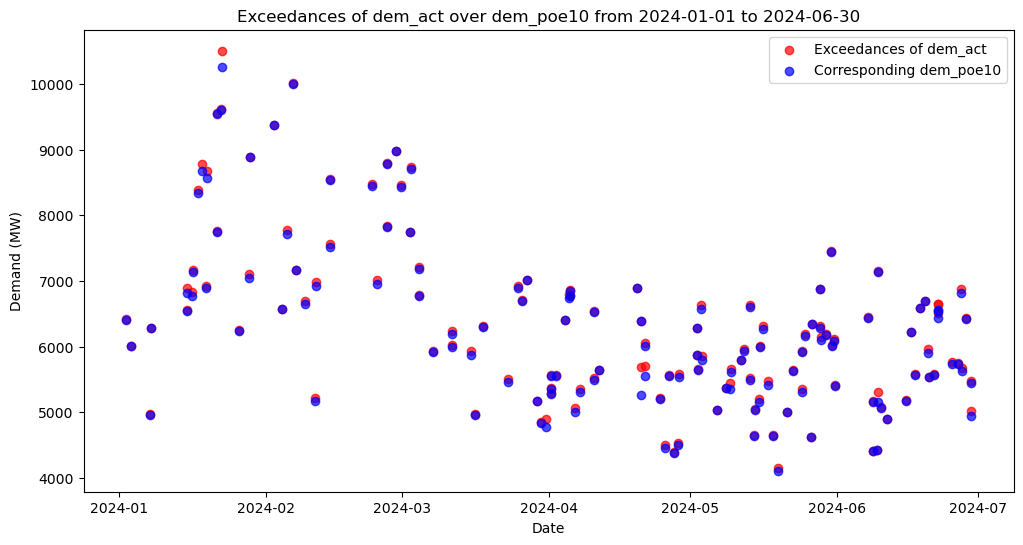

In [245]:
# Filter data for the specified date range and where dem_act exceeds dem_poe10
exceedances_df = hourly_df[
    (hourly_df['time'] >= '2024-01-01') & 
    (hourly_df['time'] <= '2024-06-30') & 
    (hourly_df['dem_act'] > hourly_df['dem_poe10'])
]

# Plot the exceedances as points
plt.figure(figsize=(12, 6))
plt.scatter(exceedances_df['time'], exceedances_df['dem_act'], color='red', label='Exceedances of dem_act', alpha=0.7)
plt.scatter(exceedances_df['time'], exceedances_df['dem_poe10'], color='blue', label='Corresponding dem_poe10', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Exceedances of dem_act over dem_poe10 from 2024-01-01 to 2024-06-30')
plt.legend()
plt.show()

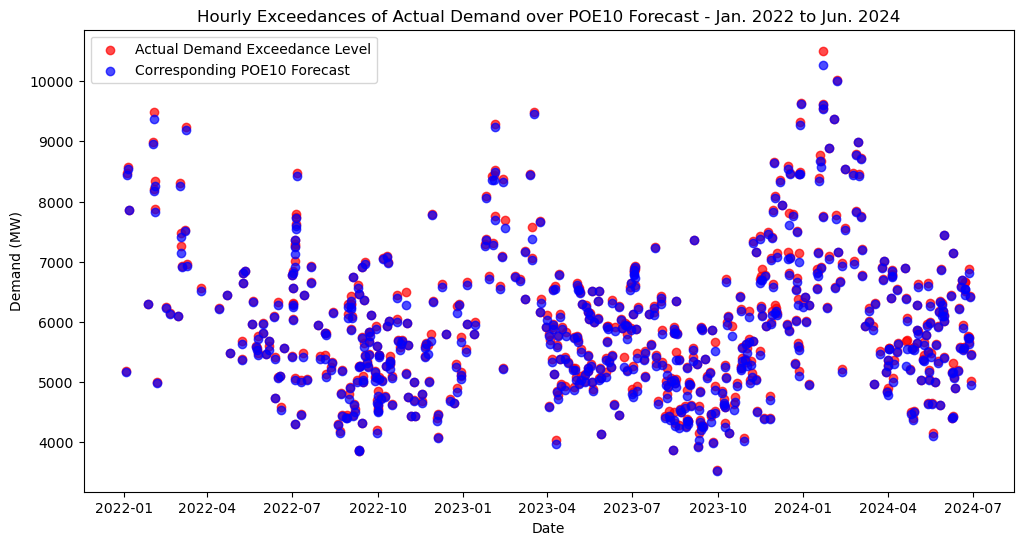

In [246]:
# Filtering for exceedances
full_exceedances_df = hourly_df[ 
    (hourly_df['dem_act'] > hourly_df['dem_poe10'])
]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(full_exceedances_df['time'], full_exceedances_df['dem_act'], color='red', label='Actual Demand Exceedance Level', alpha=0.7)
plt.scatter(full_exceedances_df['time'], full_exceedances_df['dem_poe10'], color='blue', label='Corresponding POE10 Forecast', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Hourly Exceedances of Actual Demand over POE10 Forecast - Jan. 2022 to Jun. 2024')
plt.legend()
plt.show()

## EDA Plotting

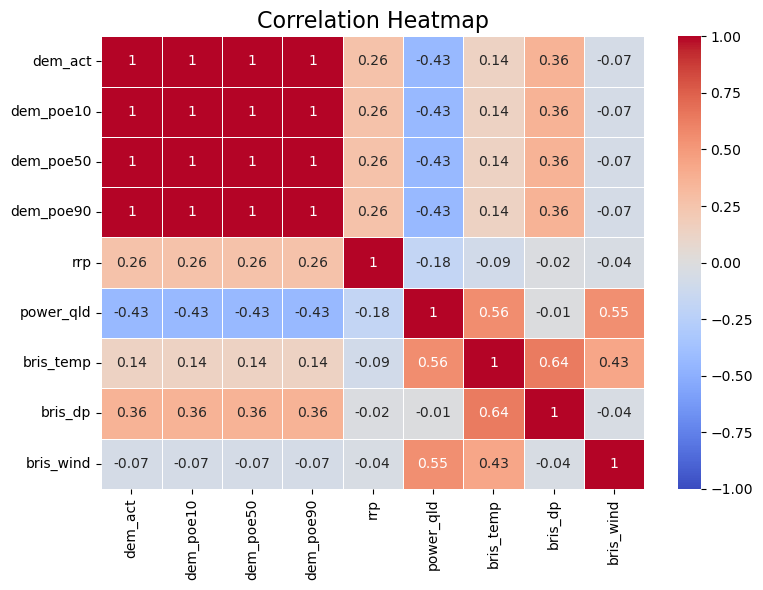

In [247]:
# Plotting heatmap of correlation - all numeric, full 2.5 years
numeric_cols = ['dem_act', 'dem_poe10', 'dem_poe50', 'dem_poe90', 'rrp', 'power_qld', 'bris_temp', 'bris_dp', 'bris_wind']
corr_matrix = hourly_df[numeric_cols].corr().round(2)
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

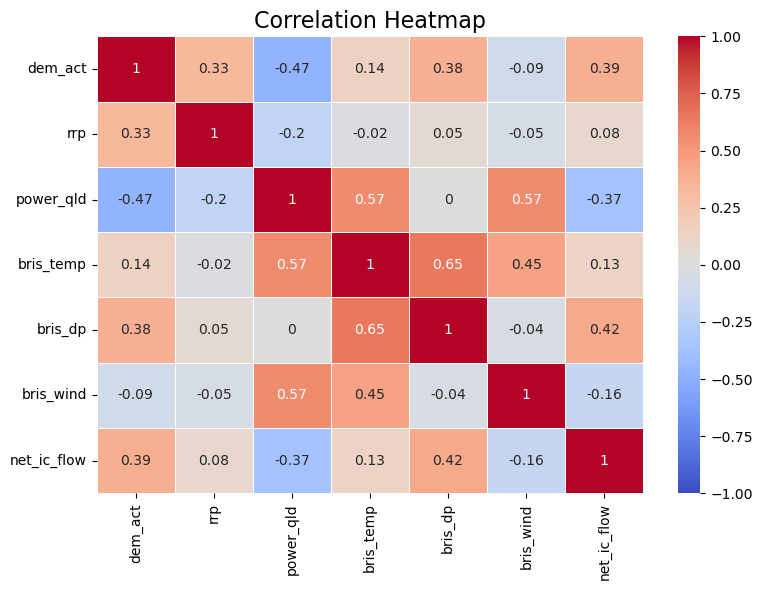

In [248]:
# Plotting heatmap of correlation - all numeric incl. IC flow (shorter timeframe)
numeric_cols = ['dem_act', 'rrp', 'power_qld', 'bris_temp', 'bris_dp', 'bris_wind', 'net_ic_flow']
corr_matrix = hourly_ic_df[numeric_cols].corr().round(2)
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [249]:
# Smoother function
def smoother(ser, n):
    return ser.rolling(n).mean()

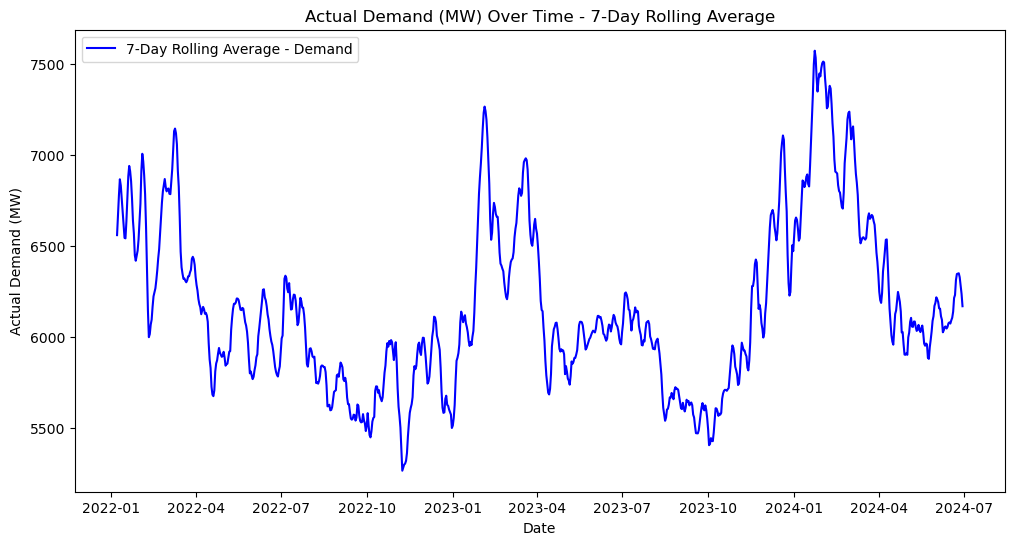

In [250]:
# Plotting 'dem_act' over time in 'daily_df'
plt.figure(figsize=(12, 6))
plt.plot(daily_df['date'], smoother(daily_df['dem_act'], 7), label='7-Day Rolling Average - Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Actual Demand (MW)')
plt.title('Actual Demand (MW) Over Time - 7-Day Rolling Average')
plt.legend()
plt.show()

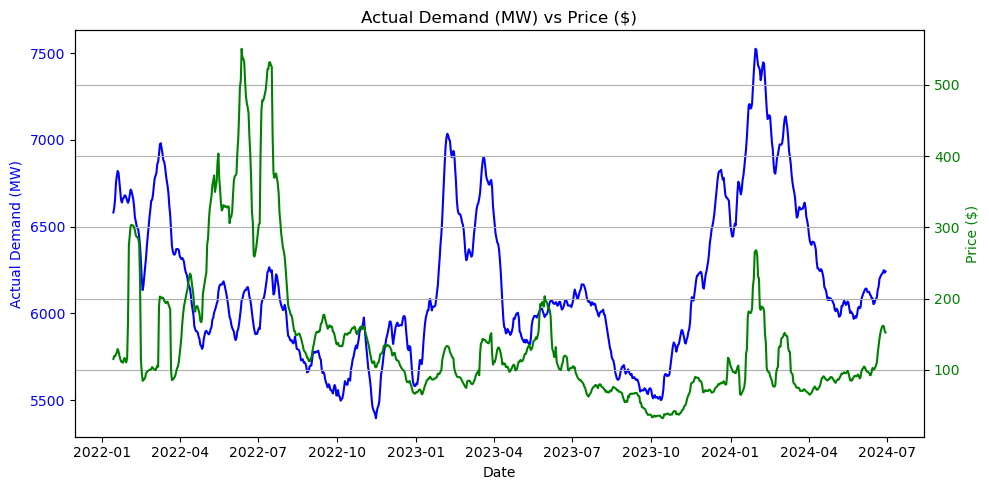

In [251]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot dem_act on the primary y-axis
ax1.plot(daily_df['date'], smoother(daily_df['dem_act'],14), color='blue', label='Actual Demand (dem_act)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot rrp
ax2 = ax1.twinx()
ax2.plot(daily_df['date'], smoother(daily_df['rrp'],14), color='green', label='Price ($)')
ax2.set_ylabel('Price ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Plotting with labels
plt.title('Actual Demand (MW) vs Price ($)')
fig.tight_layout()
plt.grid()
plt.show()

- Observe some correlation / relationship between price and demand, albeit volatile
- Also note plot highly sensitive to smoother n (rolling avg)

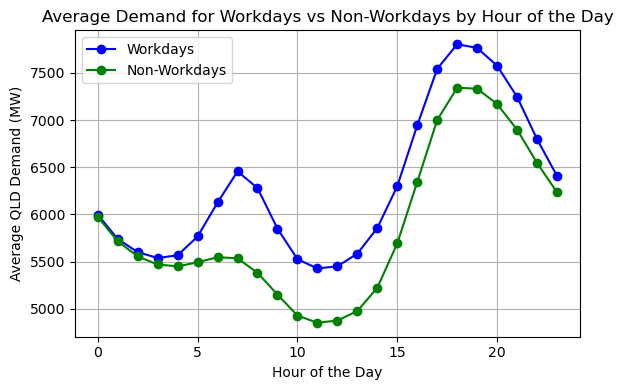

In [252]:
# Plotting average workday v non-workday
# Filtering data
non_workdays_df = hourly_df[(hourly_df['dow'].isin([5, 6])) | (hourly_df['public_holiday'] == 1)]
workdays_df = hourly_df[(~hourly_df['dow'].isin([5, 6])) & (hourly_df['public_holiday'] != 1)]

# Calculating averages
non_workday_avg_demand = non_workdays_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
workday_avg_demand = workdays_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()

# plotting
plt.figure(figsize=(6, 4))
plt.plot(workday_avg_demand.index, workday_avg_demand, label='Workdays', color='blue', linestyle='-', marker='o')
plt.plot(non_workday_avg_demand.index, non_workday_avg_demand, label='Non-Workdays', color='green', linestyle='-', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average QLD Demand (MW)')
plt.title('Average Demand for Workdays vs Non-Workdays by Hour of the Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

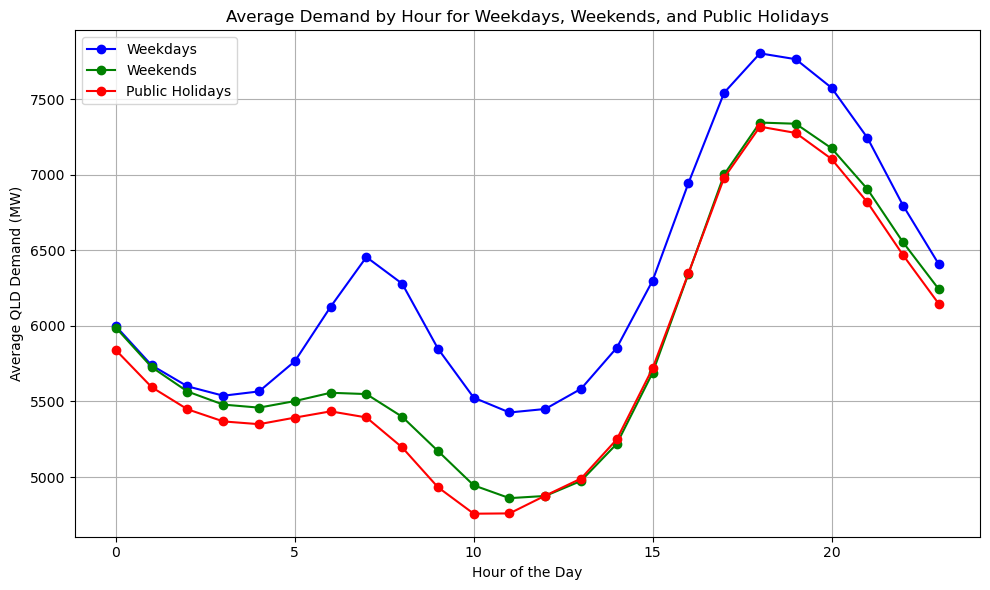

In [253]:
# Filtering to distinguish PHs from weekends
weekends_df = hourly_df[hourly_df['dow'].isin([5, 6])]
public_holidays_df = hourly_df[hourly_df['public_holiday'] == 1]
weekdays_df = hourly_df[(~hourly_df['dow'].isin([5, 6])) & (hourly_df['public_holiday'] != 1)]

# Calculating averages
weekend_avg_demand = weekends_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
public_holiday_avg_demand = public_holidays_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
weekday_avg_demand = weekdays_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekday_avg_demand.index, weekday_avg_demand, label='Weekdays', color='blue', linestyle='-', marker='o')
plt.plot(weekend_avg_demand.index, weekend_avg_demand, label='Weekends', color='green', linestyle='-', marker='o')
plt.plot(public_holiday_avg_demand.index, public_holiday_avg_demand, label='Public Holidays', color='red', linestyle='-', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average QLD Demand (MW)')
plt.title('Average Demand by Hour for Weekdays, Weekends, and Public Holidays')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- To interpret above properly will need to find distribution of PHs in dataset across time - i.e. how many fall in summer, winter, etc as this will affect the demand ultimately
- Weekends and weekdays are an equal 1/4 composite basically of each season so they represent true seasonal averages

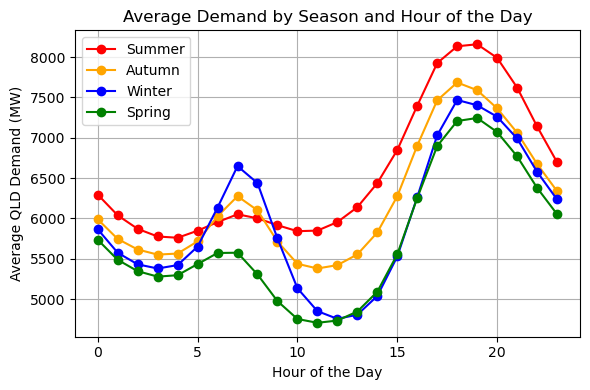

In [254]:
# Define the seasons using the 'month' column
summer_df = hourly_df[hourly_df['month'].isin([12, 1, 2])]
autumn_df = hourly_df[hourly_df['month'].isin([3, 4, 5])]
winter_df = hourly_df[hourly_df['month'].isin([6, 7, 8])]
spring_df = hourly_df[hourly_df['month'].isin([9, 10, 11])]

# Calculate the average demand for each season by the hour of the day
summer_avg_demand = summer_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
autumn_avg_demand = autumn_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
winter_avg_demand = winter_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()
spring_avg_demand = spring_df.groupby(hourly_df['time'].dt.hour)['dem_act'].mean()

# Plot the results
plt.figure(figsize=(6, 4))

# Plot each season's average demand by hour
plt.plot(summer_avg_demand.index, summer_avg_demand, label='Summer', color='red', linestyle='-', marker='o')
plt.plot(autumn_avg_demand.index, autumn_avg_demand, label='Autumn', color='orange', linestyle='-', marker='o')
plt.plot(winter_avg_demand.index, winter_avg_demand, label='Winter', color='blue', linestyle='-', marker='o')
plt.plot(spring_avg_demand.index, spring_avg_demand, label='Spring', color='green', linestyle='-', marker='o')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average QLD Demand (MW)')
plt.title('Average Demand by Season and Hour of the Day')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

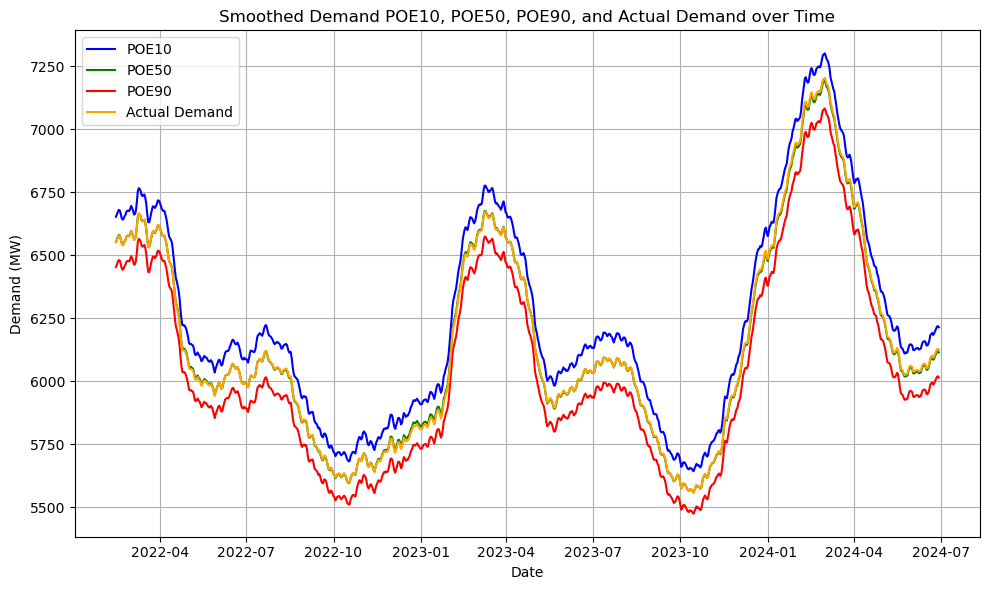

In [255]:
# Plotting demand against 3 x POE bounds with smoother
poe10_smoothed = smoother(daily_df['dem_poe10'], 45) 
poe50_smoothed = smoother(daily_df['dem_poe50'], 45)  
poe90_smoothed = smoother(daily_df['dem_poe90'], 45)
dem_act_smoothed = smoother(daily_df['dem_act'], 45) 

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_df['date'], poe10_smoothed, label='POE10', color='blue', linestyle='-')
plt.plot(daily_df['date'], poe50_smoothed, label='POE50', color='green', linestyle='-')
plt.plot(daily_df['date'], poe90_smoothed, label='POE90', color='red', linestyle='-')
plt.plot(daily_df['date'], dem_act_smoothed, label='Actual Demand', color='orange', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Smoothed Demand POE10, POE50, POE90, and Actual Demand over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [256]:
daily_df.head()

date   dem_poe10    dem_poe50    dem_poe90      dem_act         rrp  \
0 2022-01-01  6098.23913  6002.804348  5907.130435  6007.108696   78.422174   
1 2022-01-02  5960.18750  5866.687500  5773.062500  5849.354167   89.313194   
2 2022-01-03  6192.31250  6094.604167  5997.000000  6095.895833   78.416007   
3 2022-01-04  6919.56250  6818.354167  6716.979167  6830.958333  106.801979   
4 2022-01-05  7068.25000  6965.041667  6861.875000  6972.666667  103.041007   

   power_qld  bris_temp  bris_wind    bris_dp  public_holiday  dow  doy  month  
0  49663.513  22.241304   2.195652  19.589130               0    5    1      1  
1  79633.350  23.550000   3.235417  17.402083               0    6    2      1  
2  87421.584  25.612500   5.681250  16.231250               1    0    3      1  
3  86102.919  26.952083   5.287500  18.062500               0    1    4      1  
4  78330.986  26.060417   4.493750  20.779167               0    2    5      1

## Plotting of IC data

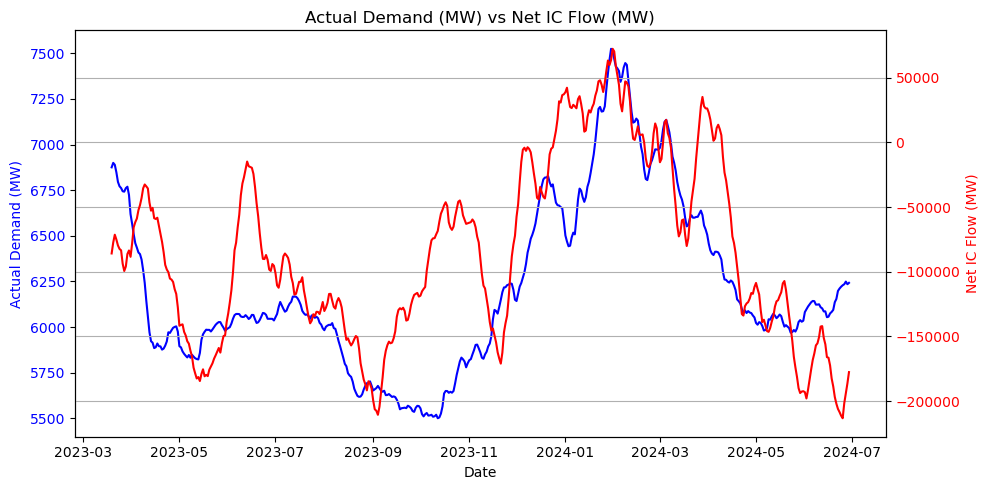

In [257]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot dem_act on the primary y-axis
ax1.plot(daily_ic_df['date'], smoother(daily_ic_df['dem_act'], 14), color='blue', label='Actual Demand (dem_act)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot net_ic_flow
ax2 = ax1.twinx()
ax2.plot(daily_ic_df['date'], smoother(daily_ic_df['net_ic_flow'], 14), color='red', label='Net IC Flow')
ax2.set_ylabel('Net IC Flow (MW)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and grid
plt.title('Actual Demand (MW) vs Net IC Flow (MW)')
fig.tight_layout()
plt.grid()

# Show plot
plt.show()


- Note more longitudinal data would be nice here ^ to gauge if correlated together better (see if deviations are random or regular events...)

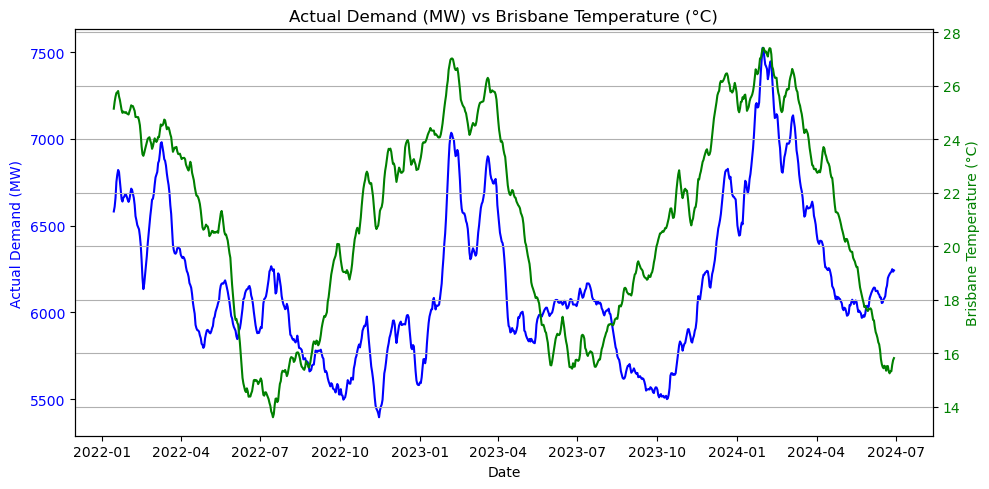

In [258]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot dem_act on the primary y-axis
ax1.plot(daily_df['date'], smoother(daily_df['dem_act'], 14), color='blue', label='Actual Demand (dem_act)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot bris_temp
ax2 = ax1.twinx()
ax2.plot(daily_df['date'], smoother(daily_df['bris_temp'], 14), color='green', label='Brisbane Temperature')
ax2.set_ylabel('Brisbane Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add titles and grid
plt.title('Actual Demand (MW) vs Brisbane Temperature (°C)')
fig.tight_layout()
plt.grid()

# Show plot
plt.show()

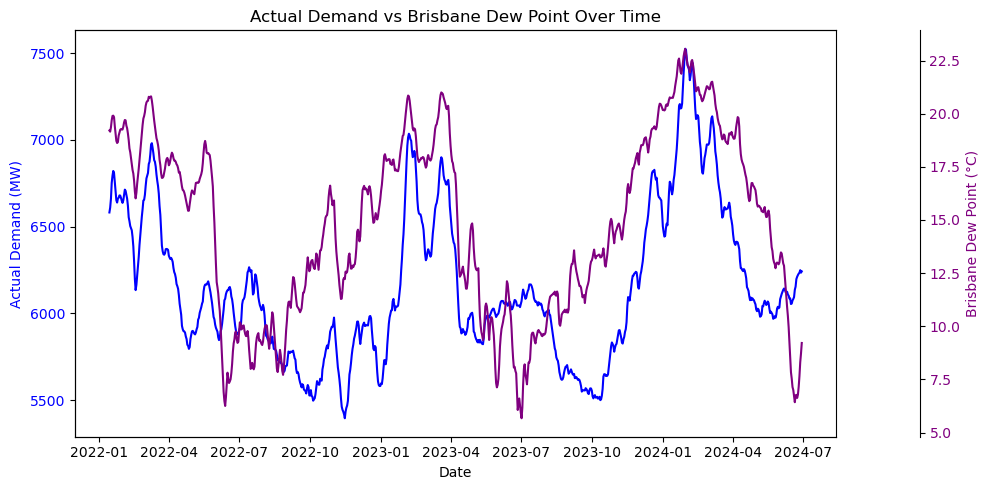

In [259]:
# Dew point v demand
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(daily_df['date'], smoother(daily_df['dem_act'], 14), color='blue', label='Actual Demand (dem_act)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot bris_temp
ax2 = ax1.twinx()
ax2.spines["right"].set_position(("outward", 60))  # Offset the secondary axis to avoid overlap
ax2.plot(daily_df['date'], smoother(daily_df['bris_dp'], 14), color='purple', label='Brisbane Dew Point')
ax2.set_ylabel('Brisbane Dew Point (°C)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add title, grid, show
plt.title('Actual Demand vs Brisbane Dew Point Over Time')
fig.tight_layout()
plt.grid(axis='x')
plt.show()

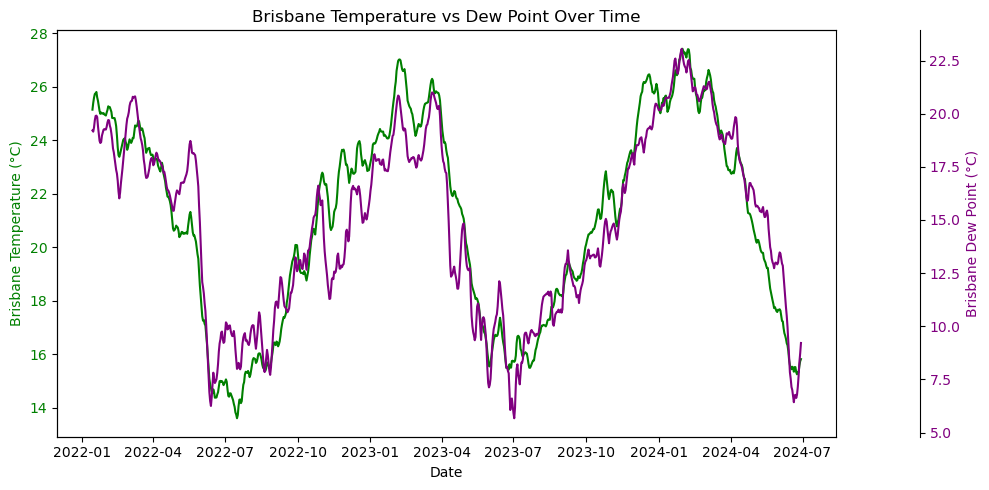

In [260]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot bris_temp on the primary y-axis
ax1.plot(daily_df['date'], smoother(daily_df['bris_temp'], 14), color='green', label='Brisbane Temperature')
ax1.set_xlabel('Date')
ax1.set_ylabel('Brisbane Temperature (°C)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary y-axis to plot bris_dp
ax2 = ax1.twinx()
ax2.spines["right"].set_position(("outward", 60))  # Offset the secondary axis to avoid overlap
ax2.plot(daily_df['date'], smoother(daily_df['bris_dp'], 14), color='purple', label='Brisbane Dew Point')
ax2.set_ylabel('Brisbane Dew Point (°C)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add title, grid, show
plt.title('Brisbane Temperature vs Dew Point Over Time')
fig.tight_layout()
plt.grid(axis='x')
plt.show()


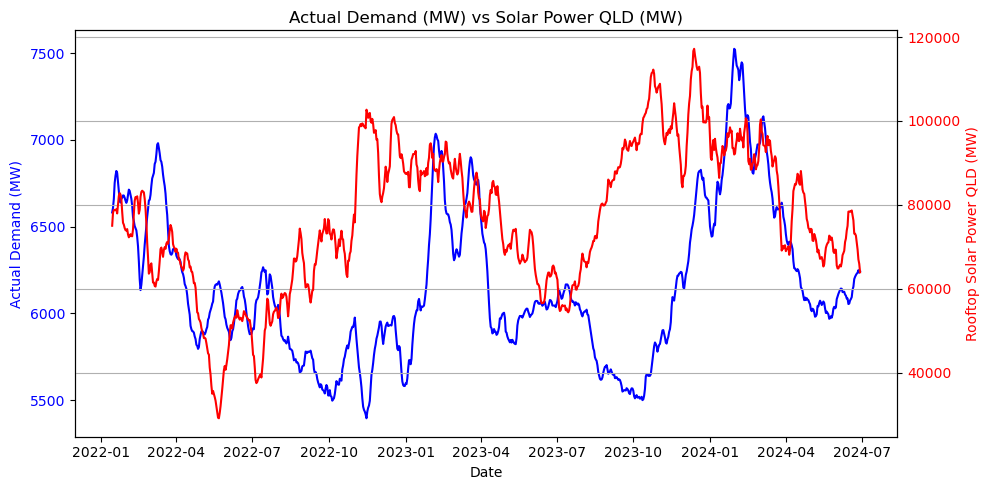

In [261]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot dem_act on the primary y-axis
ax1.plot(daily_df['date'], smoother(daily_df['dem_act'], 14), color='blue', label='Actual Demand (dem_act)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Demand (MW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot power_qld
ax2 = ax1.twinx()
ax2.plot(daily_df['date'], smoother(daily_df['power_qld'], 14), color='red', label='Power QLD')
ax2.set_ylabel('Rooftop Solar Power QLD (MW)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and grid
plt.title('Actual Demand (MW) vs Solar Power QLD (MW)')
fig.tight_layout()
plt.grid()

# Show plot
plt.show()

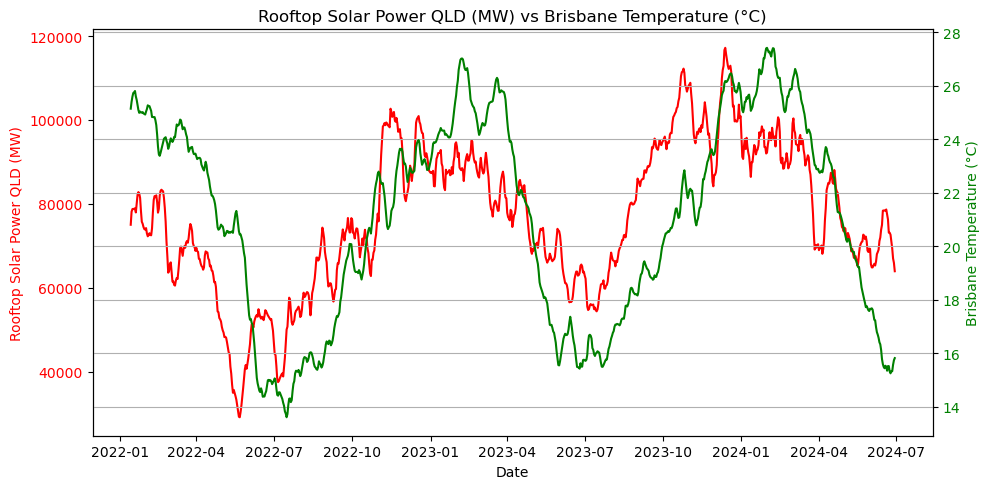

In [262]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot power_qld on the primary y-axis
ax1.plot(daily_df['date'], smoother(daily_df['power_qld'], 14), color='red', label='Power QLD')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rooftop Solar Power QLD (MW)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis to plot bris_temp
ax2 = ax1.twinx()
ax2.plot(daily_df['date'], smoother(daily_df['bris_temp'], 14), color='green', label='Brisbane Temperature')
ax2.set_ylabel('Brisbane Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add titles and grid
plt.title('Rooftop Solar Power QLD (MW) vs Brisbane Temperature (°C)')
fig.tight_layout()
plt.grid()

# Show plot
plt.show()

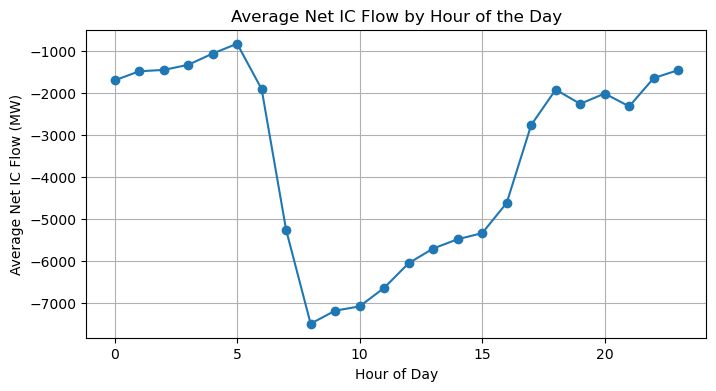

In [263]:
# Plotting hourly averages
hourly_avg = hourly_ic_df.groupby('hour')['net_ic_flow'].mean()
plt.figure(figsize=(8, 4))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Net IC Flow (MW)')
plt.title('Average Net IC Flow by Hour of the Day')
plt.grid(True)
plt.show()

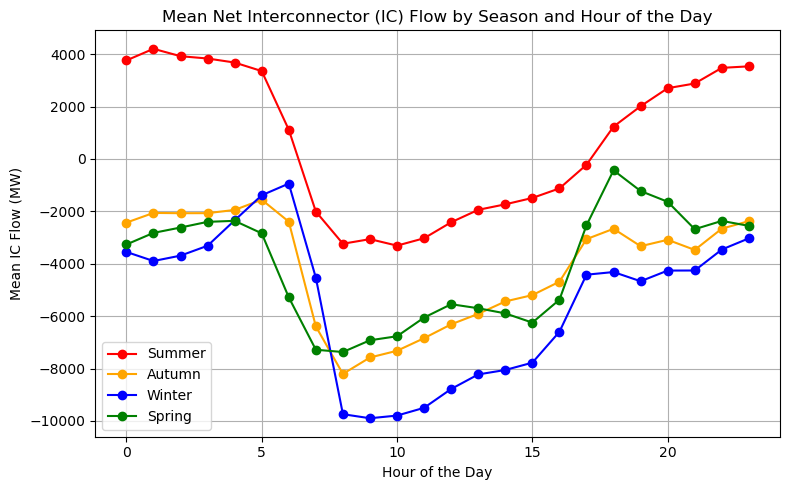

In [264]:
# Plotting by season
summer_df = hourly_ic_df[hourly_ic_df['month'].isin([12, 1, 2])]
autumn_df = hourly_ic_df[hourly_ic_df['month'].isin([3, 4, 5])]
winter_df = hourly_ic_df[hourly_ic_df['month'].isin([6, 7, 8])]
spring_df = hourly_ic_df[hourly_ic_df['month'].isin([9, 10, 11])]

# Calculating averages
summer_avg = summer_df.groupby(hourly_ic_df['time'].dt.hour)['net_ic_flow'].mean()
autumn_avg = autumn_df.groupby(hourly_ic_df['time'].dt.hour)['net_ic_flow'].mean()
winter_avg = winter_df.groupby(hourly_ic_df['time'].dt.hour)['net_ic_flow'].mean()
spring_avg = spring_df.groupby(hourly_ic_df['time'].dt.hour)['net_ic_flow'].mean()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(summer_avg.index, summer_avg, label='Summer', color='red', linestyle='-', marker='o')
plt.plot(autumn_avg.index, autumn_avg, label='Autumn', color='orange', linestyle='-', marker='o')
plt.plot(winter_avg.index, winter_avg, label='Winter', color='blue', linestyle='-', marker='o')
plt.plot(spring_avg.index, spring_avg, label='Spring', color='green', linestyle='-', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean IC Flow (MW)')
plt.title('Mean Net Interconnector (IC) Flow by Season and Hour of the Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Interesting Summer is distinct from the other 3 seasons - likely QLD needs the energy more in Summer than NSW..? also only based on one year of data, hard to tell

## Investigating Lags

In [265]:
# Defining functions for ACF and PACF plotting, including correlation on ACF plot
def plot_lag(x, lag=1, ax=None, **kwargs):
    x_ = x.shift(lag)
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3, )
    line = dict(color='C3', )

    ax = sns.regplot(x=x_,y=y_,scatter_kws=scatter_kws,line_kws=line,lowess=True,ax=ax,**kwargs)

    at = AnchoredText(f"{y_.corr(x_):.2f}",prop=dict(size="large"),frameon=True,loc="upper left",)
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

# PACF plot function
def plot_autocorrelation(x, lags=6, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", 2)
    kwargs.setdefault("ncols", math.ceil(lags / 2))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, 2  * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(2 * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = plot_lag(x, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag #{k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

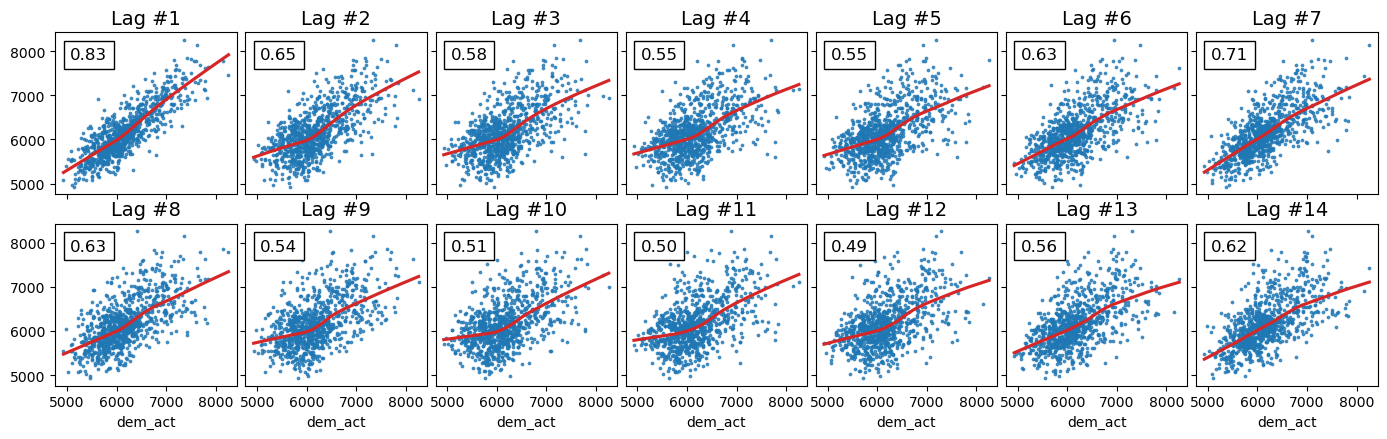

In [266]:
# Plotting autocorrelation - 14 days
acf = plot_autocorrelation(daily_df["dem_act"], lags=14)

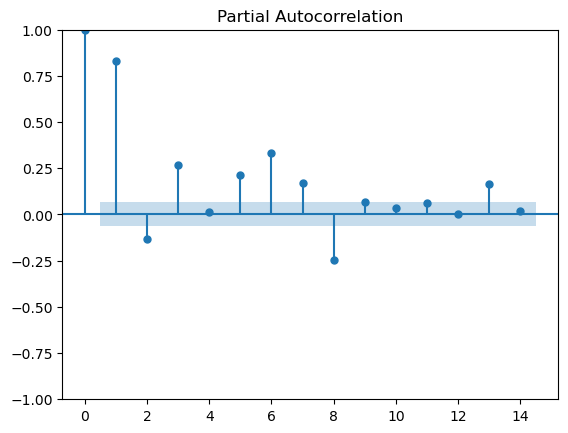

In [267]:
# Plotting partial autocorrelation - 14 days
pacf = plot_pacf(daily_df["dem_act"], lags=14)

# Deriving Features

- note that the first 8 lags (excl. lag 4) appear statistically significant - can test models with 1) first 8 lags, 2) first 7 lags, 3) first 3 lags?
- time-based - day of week, day of year, month, public holiday
- moving averages of demand - testing various MA / EMA
- lags of demand - testing various lags

In [268]:
# Defining function to add lagged features
def create_lag_features(df, lags=2):
  y = daily_df.loc[:, "dem_act"]
  for lag in range(lags):
    df[f"lag{lag + 1}"] = y.shift(lag + 1)
  return df

In [269]:
daily_df = create_lag_features(daily_df, lags=8)

In [270]:
daily_df.head(5)

date   dem_poe10    dem_poe50    dem_poe90      dem_act         rrp  \
0 2022-01-01  6098.23913  6002.804348  5907.130435  6007.108696   78.422174   
1 2022-01-02  5960.18750  5866.687500  5773.062500  5849.354167   89.313194   
2 2022-01-03  6192.31250  6094.604167  5997.000000  6095.895833   78.416007   
3 2022-01-04  6919.56250  6818.354167  6716.979167  6830.958333  106.801979   
4 2022-01-05  7068.25000  6965.041667  6861.875000  6972.666667  103.041007   

   power_qld  bris_temp  bris_wind    bris_dp  ...  doy  month         lag1  \
0  49663.513  22.241304   2.195652  19.589130  ...    1      1          NaN   
1  79633.350  23.550000   3.235417  17.402083  ...    2      1  6007.108696   
2  87421.584  25.612500   5.681250  16.231250  ...    3      1  5849.354167   
3  86102.919  26.952083   5.287500  18.062500  ...    4      1  6095.895833   
4  78330.986  26.060417   4.493750  20.779167  ...    5      1  6830.958333   

          lag2         lag3         lag4  lag5  lag6  lag7  lag8  
0          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
1          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
2  6007.108696          NaN          NaN   NaN   NaN   NaN   NaN  
3  5849.354167  6007.108696          NaN   NaN   NaN   NaN   NaN  
4  6095.895833  5849.354167  6007.108696   NaN   NaN   NaN   NaN  

[5 rows x 22 columns]

In [271]:
# Replicating for DF with IC flow data here
daily_ic_df = create_lag_features(daily_ic_df, lags=8)

- note will need to shorten the test period for this dataset - seasonality may not play much of a role
- intending on training for 12 months to capture yearly seasonality effects
- count months = 16 in total, so 12/4 is 75/25 - justifiable as training for one year, allows model to learn time of year effects

In [272]:
daily_ic_df.head(5)

date   net_ic_flow    dem_poe10    dem_poe50    dem_poe90  \
0 2023-03-06 -204433.72496  6613.166667  6516.916667  6420.854167   
1 2023-03-07 -146879.12472  6898.395833  6797.750000  6697.000000   
2 2023-03-08  -47579.92761  7276.916667  7170.583333  7064.500000   
3 2023-03-09  -26352.12395  7265.458333  7159.437500  7053.333333   
4 2023-03-10  -87712.82305  6900.666667  6800.604167  6700.562500   

       dem_act         rrp   power_qld  bris_temp  bris_wind  ...  doy  month  \
0  6517.416667   83.485243  102113.555  25.070833   3.200000  ...   65      3   
1  6798.666667   83.655000   97454.941  26.427083   3.179167  ...   66      3   
2  7169.791667   83.664271   57054.973  27.000000   2.489583  ...   67      3   
3  7161.625000  101.587153   43981.622  26.633333   1.295833  ...   68      3   
4  6800.520833   96.059514   54227.769  24.579167   2.150000  ...   69      3   

          lag1         lag2         lag3         lag4  lag5  lag6  lag7  lag8  
0          NaN          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
1  6007.108696          NaN          NaN          NaN   NaN   NaN   NaN   NaN  
2  5849.354167  6007.108696          NaN          NaN   NaN   NaN   NaN   NaN  
3  6095.895833  5849.354167  6007.108696          NaN   NaN   NaN   NaN   NaN  
4  6830.958333  6095.895833  5849.354167  6007.108696   NaN   NaN   NaN   NaN  

[5 rows x 23 columns]

## Splitting Data

In [273]:
# Splitting by date - train 2022-23, test 2024 (until June)
training_mask = daily_df["date"] < "2024-01-01"
training_data = daily_df.loc[training_mask]
print(training_data.shape)

testing_mask = daily_df["date"] >= "2024-01-01"
testing_data = daily_df.loc[testing_mask]
print(testing_data.shape)

(730, 22)
(181, 22)


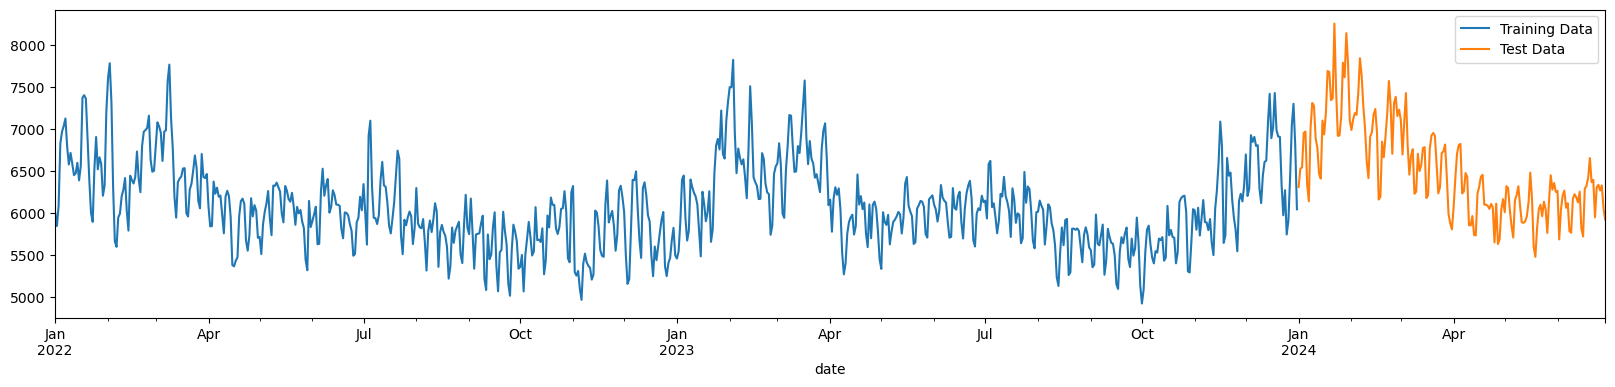

In [274]:
# Plotting train/test split over time
figure, ax = plt.subplots(figsize=(20, 4))
training_data.plot(ax=ax, label="Training Data", x="date", y="dem_act")
testing_data.plot(ax=ax, label="Test Data", x="date", y="dem_act")
plt.show()

In [275]:
# Defining splits
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8"]]
y_train = training_data["dem_act"]

X_test = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8"]]
y_test = testing_data["dem_act"]

## Models

In [276]:
# XGBoost - without IC flow
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_xgb_lag = XGBRegressor()
parameters = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.5, 0.7]
}

grid_search_xgb_lag = GridSearchCV(estimator=model_xgb_lag, cv=cv_split, param_grid=parameters)
grid_search_xgb_lag.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 300]})

In [277]:
# LightGBM - without IC flow
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_lgb_lag = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 5],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7]
}

# Suppress LightGBM output
lgbm_params = {"verbosity": -1}
model_lgb_lag.set_params(**lgbm_params)

# Run GridSearchCV with the reduced parameter grid
grid_search_lgb_lag = GridSearchCV(estimator=model_lgb_lag, cv=cv_split, param_grid=parameters, verbose=0)
grid_search_lgb_lag.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(verbosity=-1),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'num_leaves': [10, 20]})

In [278]:
# Defining function for model evaluation, using MAPE, MSE and MAE
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

In [279]:
# Defining function to plot predicted v actual
def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Predicted"])
  plt.show()

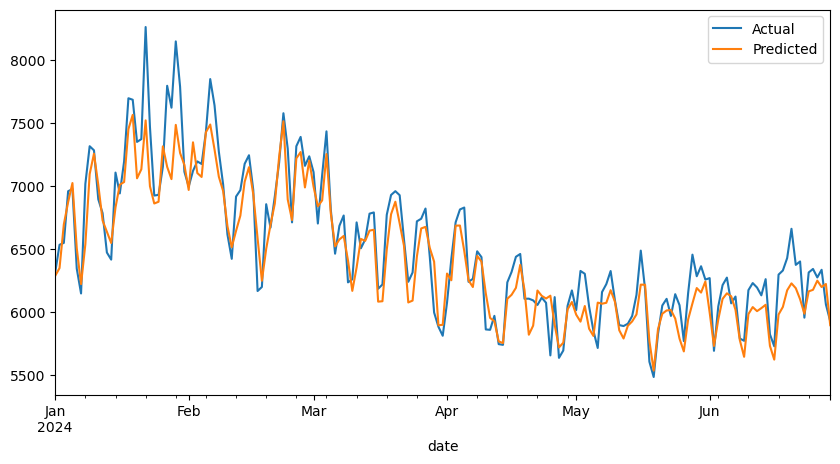

MAE: 157.2818012272675
MSE: 43004.354681756624
MAPE: 0.023667478386053535


In [280]:
# Evaluating GridSearch results - XGBoost - without IC flow
xgb_lag_prediction = grid_search_xgb_lag.predict(X_test)
plot_predictions(testing_dates, y_test, xgb_lag_prediction)
evaluate_model(y_test, xgb_lag_prediction)

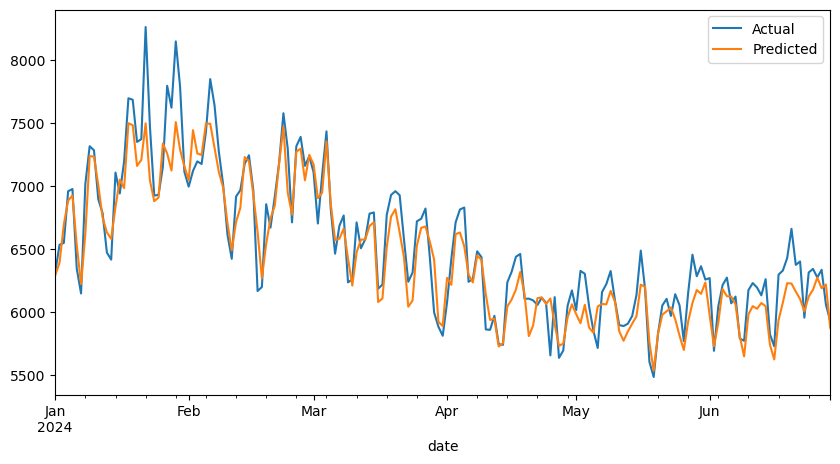

MAE: 152.0053612822139
MSE: 39864.895781487954
MAPE: 0.022958829097412044


In [281]:
# Evaluating GridSearch results - LGBM - without IC flow
lgb_prediction = grid_search_lgb_lag.predict(X_test)
plot_predictions(testing_dates, y_test, lgb_prediction)
evaluate_model(y_test, lgb_prediction)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

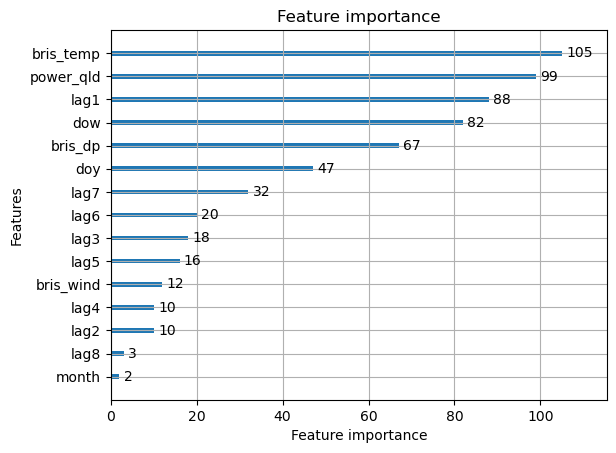

In [282]:
lgb.plot_importance(grid_search_lgb_lag.best_estimator_) # based on split counts

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

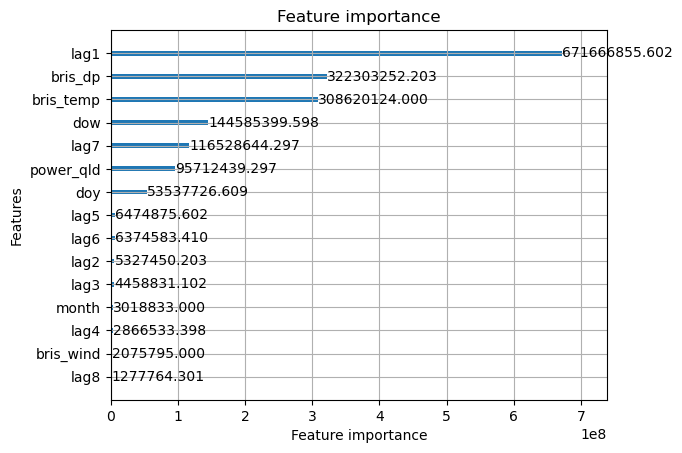

In [283]:
lgb.plot_importance(grid_search_lgb_lag.best_estimator_, importance_type='gain') # based on accuracy gain - only lags 1 + 7 appear important of lagged variables (demand yesterday + 1 week ago)

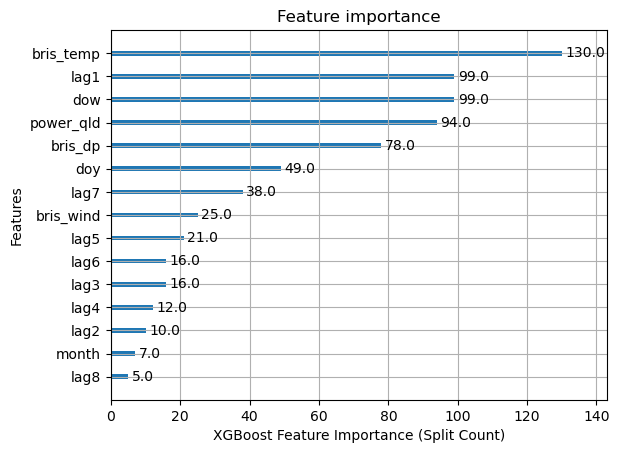

In [284]:
# split counts for XGB
plot_importance(grid_search_xgb_lag.best_estimator_, importance_type='weight', xlabel='XGBoost Feature Importance (Split Count)')
plt.show()

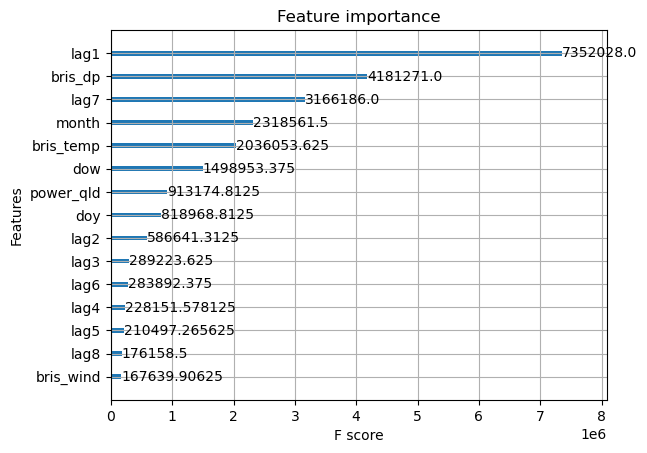

In [285]:
# XGB importances based on gain
plot_importance(grid_search_xgb_lag.best_estimator_, importance_type='gain') # based on accuracy improvement
plt.show()

- Clear that lag 1 and lag 7 are the most influential lags - thus reducing from 8 to 7 moving forward (also observe lag 8 is negative thus confusing the prediction, from PACF plot earlier)

## EMA & Rolling Avg - Derivation & Data Splitting

Rationale:wanting to test MAs and EMAs for 2, 3, 5, 7 windows and retain only the best. Will start with MA then compare to EMA.

7 lags will be retained for now with some removed later. Lag 8 will be removed moving forward.

In [286]:
# Dropping lag 8 
columns_to_drop = ['lag8']
daily_df = daily_df.drop(columns=columns_to_drop)
daily_ic_df = daily_ic_df.drop(columns=columns_to_drop)

In [287]:
daily_ic_df.head()

date   net_ic_flow    dem_poe10    dem_poe50    dem_poe90  \
0 2023-03-06 -204433.72496  6613.166667  6516.916667  6420.854167   
1 2023-03-07 -146879.12472  6898.395833  6797.750000  6697.000000   
2 2023-03-08  -47579.92761  7276.916667  7170.583333  7064.500000   
3 2023-03-09  -26352.12395  7265.458333  7159.437500  7053.333333   
4 2023-03-10  -87712.82305  6900.666667  6800.604167  6700.562500   

       dem_act         rrp   power_qld  bris_temp  bris_wind  ...  dow  doy  \
0  6517.416667   83.485243  102113.555  25.070833   3.200000  ...    0   65   
1  6798.666667   83.655000   97454.941  26.427083   3.179167  ...    1   66   
2  7169.791667   83.664271   57054.973  27.000000   2.489583  ...    2   67   
3  7161.625000  101.587153   43981.622  26.633333   1.295833  ...    3   68   
4  6800.520833   96.059514   54227.769  24.579167   2.150000  ...    4   69   

   month         lag1         lag2         lag3         lag4  lag5  lag6  lag7  
0      3          NaN          NaN          NaN          NaN   NaN   NaN   NaN  
1      3  6007.108696          NaN          NaN          NaN   NaN   NaN   NaN  
2      3  5849.354167  6007.108696          NaN          NaN   NaN   NaN   NaN  
3      3  6095.895833  5849.354167  6007.108696          NaN   NaN   NaN   NaN  
4      3  6830.958333  6095.895833  5849.354167  6007.108696   NaN   NaN   NaN  

[5 rows x 22 columns]

In [288]:
# Adding rolling avg cols
daily_df['ma7'] = daily_df['dem_act'].shift(1).rolling(window=7).mean()
daily_df['ma5'] = daily_df['dem_act'].shift(1).rolling(window=5).mean()
daily_df['ma3'] = daily_df['dem_act'].shift(1).rolling(window=3).mean()
daily_df['ma2'] = daily_df['dem_act'].shift(1).rolling(window=2).mean()

In [289]:
# EMA cols
daily_df['ema7'] = daily_df['dem_act'].shift(1).ewm(span=7, adjust=False).mean()
daily_df['ema5'] = daily_df['dem_act'].shift(1).ewm(span=5, adjust=False).mean()
daily_df['ema3'] = daily_df['dem_act'].shift(1).ewm(span=3, adjust=False).mean()
daily_df['ema2'] = daily_df['dem_act'].shift(1).ewm(span=2, adjust=False).mean()

In [290]:
# Splitting by date - train 2022-23, test 2024 (until June)
training_mask = daily_df["date"] < "2024-01-01"
training_data = daily_df.loc[training_mask]
print(training_data.shape)

testing_mask = daily_df["date"] >= "2024-01-01"
testing_data = daily_df.loc[testing_mask]
print(testing_data.shape)

(730, 29)
(181, 29)


In [291]:
# Preparing train and test sets for MA x 4
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train_ma2 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma2"]]
X_train_ma3 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma3"]]
X_train_ma5 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma5"]]
X_train_ma7 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma7"]]
y_train = training_data["dem_act"]

X_test_ma2 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma2"]]
X_test_ma3 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma3"]]
X_test_ma5 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma5"]]
X_test_ma7 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma7"]]
y_test = testing_data["dem_act"]

In [292]:
# Preparing train and test sets for EMA x 4
X_train_ema2 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema2"]]
X_train_ema3 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema3"]]
X_train_ema5 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema5"]]
X_train_ema7 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema7"]]
y_train = training_data["dem_act"]

X_test_ema2 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema2"]]
X_test_ema3 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema3"]]
X_test_ema5 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema5"]]
X_test_ema7 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema7"]]
y_test = testing_data["dem_act"]

## Phase 1 Models - Without IC Data (2022 - 2024)

- Here will be testing 3 x tree-based models - RF, XGBoost, LightGBM
- Expected that RF and XGB may perform quite similarly, in terms of accuracy and feature splits/importances etc
- Overall will be 24 sets of results (8 per model type - one for each type of MA)
- Note arbitrary choice of MA windows, etc.
- Also not like for like comparison when adding in IC data, only for curiosity purposes - how much does intrastate demand / flows influence QLD? not causal, only observational

In [293]:
# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_xgb_lag_ma = XGBRegressor()
parameters_xgb = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.5, 0.7]
}

grid_search_xgb_lag_ma2 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma3 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma5 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma7 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

grid_search_xgb_lag_ema2 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema3 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema5 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema7 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

In [294]:
# Running 8 x GSs for each XGB model variation
gs_xgb_ma2 = grid_search_xgb_lag_ma2.fit(X_train_ma2, y_train)
gs_xgb_ma3 = grid_search_xgb_lag_ma3.fit(X_train_ma3, y_train)
gs_xgb_ma5 = grid_search_xgb_lag_ma5.fit(X_train_ma5, y_train)
gs_xgb_ma7 = grid_search_xgb_lag_ma7.fit(X_train_ma7, y_train)
gs_xgb_ema2 = grid_search_xgb_lag_ema2.fit(X_train_ema2, y_train)
gs_xgb_ema3 = grid_search_xgb_lag_ema3.fit(X_train_ema3, y_train)
gs_xgb_ema5 = grid_search_xgb_lag_ema5.fit(X_train_ema5, y_train)
gs_xgb_ema7 = grid_search_xgb_lag_ema7.fit(X_train_ema7, y_train)

In [295]:
# LightGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_lgb_lag_ma = lgb.LGBMRegressor()
parameters_lgb = {
    "max_depth": [3, 5],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7]
}

# Suppress LightGBM output
lgbm_params = {"verbosity": -1}
model_lgb_lag_ma.set_params(**lgbm_params)

# Assigning one GS for each
grid_search_lgb_lag_ma2 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma3 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma5 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma7 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

grid_search_lgb_lag_ema2 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema3 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema5 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema7 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

In [296]:
# Running 8 x GSs for each LGB model variation
gs_lgb_ma2 = grid_search_lgb_lag_ma2.fit(X_train_ma2, y_train)
gs_lgb_ma3 = grid_search_lgb_lag_ma3.fit(X_train_ma3, y_train)
gs_lgb_ma5 = grid_search_lgb_lag_ma5.fit(X_train_ma5, y_train)
gs_lgb_ma7 = grid_search_lgb_lag_ma7.fit(X_train_ma7, y_train)
gs_lgb_ema2 = grid_search_lgb_lag_ema2.fit(X_train_ema2, y_train)
gs_lgb_ema3 = grid_search_lgb_lag_ema3.fit(X_train_ema3, y_train)
gs_lgb_ema5 = grid_search_lgb_lag_ema5.fit(X_train_ema5, y_train)
gs_lgb_ema7 = grid_search_lgb_lag_ema7.fit(X_train_ema7, y_train)

In [297]:
# RF model
model_rf = RandomForestRegressor(random_state=42)

# Defining grid search
rf_parameters = {
    "n_estimators": [100, 200],         
    "max_depth": [5, 10],              
    "min_samples_split": [2, 5],     
    "min_samples_leaf": [1, 2],      
}

# Set up time series cross-validation
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)

# Assigning one GS for each RF model variation
grid_search_rf_lag_ma2 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ma3 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ma5 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ma7 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")

grid_search_rf_lag_ema2 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ema3 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ema5 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")
grid_search_rf_lag_ema7 = GridSearchCV(estimator=model_rf, param_grid=rf_parameters, cv=cv_split, scoring="neg_mean_squared_error")

In [298]:
# Running 8 x GSs for each RF model variation
gs_rf_ma2 = grid_search_rf_lag_ma2.fit(X_train_ma2, y_train)
gs_rf_ma3 = grid_search_rf_lag_ma3.fit(X_train_ma3, y_train)
gs_rf_ma5 = grid_search_rf_lag_ma5.fit(X_train_ma5, y_train)
gs_rf_ma7 = grid_search_rf_lag_ma7.fit(X_train_ma7, y_train)
gs_rf_ema2 = grid_search_rf_lag_ema2.fit(X_train_ema2, y_train)
gs_rf_ema3 = grid_search_rf_lag_ema3.fit(X_train_ema3, y_train)
gs_rf_ema5 = grid_search_rf_lag_ema5.fit(X_train_ema5, y_train)
gs_rf_ema7 = grid_search_rf_lag_ema7.fit(X_train_ema7, y_train)

In [299]:
# Evaluating GridSearch results - XGBoost
print("\n--- Evaluating Model: XGBoost with MA2 ---")
xgb_lag_ma2_prediction = gs_xgb_ma2.predict(X_test_ma2)
evaluate_model(y_test, xgb_lag_ma2_prediction)
print("\n--- Evaluating Model: XGBoost with MA3 ---")
xgb_lag_ma3_prediction = gs_xgb_ma3.predict(X_test_ma3)
evaluate_model(y_test, xgb_lag_ma3_prediction)
print("\n--- Evaluating Model: XGBoost with MA5 ---")
xgb_lag_ma5_prediction = gs_xgb_ma5.predict(X_test_ma5)
evaluate_model(y_test, xgb_lag_ma5_prediction)
print("\n--- Evaluating Model: XGBoost with MA7 ---")
xgb_lag_ma7_prediction = gs_xgb_ma7.predict(X_test_ma7)
evaluate_model(y_test, xgb_lag_ma7_prediction)
print("\n--- Evaluating Model: XGBoost with EMA2 ---")
xgb_lag_ema2_prediction = gs_xgb_ema2.predict(X_test_ema2)
evaluate_model(y_test, xgb_lag_ema2_prediction)
print("\n--- Evaluating Model: XGBoost with EMA3 ---")
xgb_lag_ema3_prediction = gs_xgb_ema3.predict(X_test_ema3)
evaluate_model(y_test, xgb_lag_ema3_prediction)
print("\n--- Evaluating Model: XGBoost with EMA5 ---")
xgb_lag_ema5_prediction = gs_xgb_ema5.predict(X_test_ema5)
evaluate_model(y_test, xgb_lag_ema5_prediction)
print("\n--- Evaluating Model: XGBoost with EMA7 ---")
xgb_lag_ema7_prediction = gs_xgb_ema7.predict(X_test_ema7)
evaluate_model(y_test, xgb_lag_ema7_prediction)


--- Evaluating Model: XGBoost with MA2 ---
MAE: 153.26265035105894
MSE: 41926.7822016774
MAPE: 0.02309825558361239

--- Evaluating Model: XGBoost with MA3 ---
MAE: 153.77109590814916
MSE: 42478.87481070883
MAPE: 0.023155496066006132

--- Evaluating Model: XGBoost with MA5 ---
MAE: 155.38682755668736
MSE: 42153.83127744027
MAPE: 0.023417415390876346

--- Evaluating Model: XGBoost with MA7 ---
MAE: 152.37442449355433
MSE: 41628.9548957809
MAPE: 0.02290603998321256

--- Evaluating Model: XGBoost with EMA2 ---
MAE: 152.99631945643412
MSE: 40856.83216255893
MAPE: 0.023010700680237077

--- Evaluating Model: XGBoost with EMA3 ---
MAE: 150.8181786300069
MSE: 40007.09999629411
MAPE: 0.02268689336088113

--- Evaluating Model: XGBoost with EMA5 ---
MAE: 153.77097181457182
MSE: 41221.12460553186
MAPE: 0.023114984170609178

--- Evaluating Model: XGBoost with EMA7 ---
MAE: 155.27197985008056
MSE: 42451.194699808606
MAPE: 0.02331440408100719


In [300]:
# Evaluating GridSearch results - LightGBM
print("\n--- Evaluating Model: LightGBM with MA2 ---")
lgb_lag_ma2_prediction = gs_lgb_ma2.predict(X_test_ma2)
evaluate_model(y_test, lgb_lag_ma2_prediction)
print("\n--- Evaluating Model: LightGBM with MA3 ---")
lgb_lag_ma3_prediction = gs_lgb_ma3.predict(X_test_ma3)
evaluate_model(y_test, lgb_lag_ma3_prediction)
print("\n--- Evaluating Model: LightGBM with MA5 ---")
lgb_lag_ma5_prediction = gs_lgb_ma5.predict(X_test_ma5)
evaluate_model(y_test, lgb_lag_ma5_prediction)
print("\n--- Evaluating Model: LightGBM with MA7 ---")
lgb_lag_ma7_prediction = gs_lgb_ma7.predict(X_test_ma7)
evaluate_model(y_test, lgb_lag_ma7_prediction)
print("\n--- Evaluating Model: LightGBM with EMA2 ---")
lgb_lag_ema2_prediction = gs_lgb_ema2.predict(X_test_ema2)
evaluate_model(y_test, lgb_lag_ema2_prediction)
print("\n--- Evaluating Model: LightGBM with EMA3 ---")
lgb_lag_ema3_prediction = gs_lgb_ema3.predict(X_test_ema3)
evaluate_model(y_test, lgb_lag_ema3_prediction)
print("\n--- Evaluating Model: LightGBM with EMA5 ---")
lgb_lag_ema5_prediction = gs_lgb_ema5.predict(X_test_ema5)
evaluate_model(y_test, lgb_lag_ema5_prediction)
print("\n--- Evaluating Model: LightGBM with EMA7 ---")
lgb_lag_ema7_prediction = gs_lgb_ema7.predict(X_test_ema7)
evaluate_model(y_test, lgb_lag_ema7_prediction)


--- Evaluating Model: LightGBM with MA2 ---
MAE: 151.25392882559876
MSE: 40871.619479781715
MAPE: 0.022853808016556305

--- Evaluating Model: LightGBM with MA3 ---
MAE: 148.4519414361979
MSE: 40135.02443457906
MAPE: 0.02243508835956928

--- Evaluating Model: LightGBM with MA5 ---
MAE: 152.59000730729915
MSE: 40408.62790102097
MAPE: 0.023076975858591073

--- Evaluating Model: LightGBM with MA7 ---
MAE: 152.78737062818772
MSE: 40843.722128594214
MAPE: 0.02305732093944494

--- Evaluating Model: LightGBM with EMA2 ---
MAE: 165.52760134733302
MSE: 47657.84596649473
MAPE: 0.02470259992272058

--- Evaluating Model: LightGBM with EMA3 ---
MAE: 150.96145056519524
MSE: 39089.05733888664
MAPE: 0.022847659615591594

--- Evaluating Model: LightGBM with EMA5 ---
MAE: 148.8373514945771
MSE: 39725.84383667815
MAPE: 0.02249623980655652

--- Evaluating Model: LightGBM with EMA7 ---
MAE: 148.59670205246644
MSE: 40176.46683951038
MAPE: 0.022448268967574497


In [301]:
# Evaluating GridSearch results - Random Forest
print("\n--- Evaluating Model: Random Forest with MA2 ---")
rf_lag_ma2_prediction = gs_rf_ma2.predict(X_test_ma2)
evaluate_model(y_test, rf_lag_ma2_prediction)
print("\n--- Evaluating Model: Random Forest with MA3 ---")
rf_lag_ma3_prediction = gs_rf_ma3.predict(X_test_ma3)
evaluate_model(y_test, rf_lag_ma3_prediction)
print("\n--- Evaluating Model: Random Forest with MA5 ---")
rf_lag_ma5_prediction = gs_rf_ma5.predict(X_test_ma5)
evaluate_model(y_test, rf_lag_ma5_prediction)
print("\n--- Evaluating Model: Random Forest with MA7 ---")
rf_lag_ma7_prediction = gs_rf_ma7.predict(X_test_ma7)
evaluate_model(y_test, rf_lag_ma7_prediction)
print("\n--- Evaluating Model: Random Forest with EMA2 ---")
rf_lag_ema2_prediction = gs_rf_ema2.predict(X_test_ema2)
evaluate_model(y_test, rf_lag_ema2_prediction)
print("\n--- Evaluating Model: Random Forest with EMA3 ---")
rf_lag_ema3_prediction = gs_rf_ema3.predict(X_test_ema3)
evaluate_model(y_test, rf_lag_ema3_prediction)
print("\n--- Evaluating Model: Random Forest with EMA5 ---")
rf_lag_ema5_prediction = gs_rf_ema5.predict(X_test_ema5)
evaluate_model(y_test, rf_lag_ema5_prediction)
print("\n--- Evaluating Model: Random Forest with EMA7 ---")
rf_lag_ema7_prediction = gs_rf_ema7.predict(X_test_ema7)
evaluate_model(y_test, rf_lag_ema7_prediction)


--- Evaluating Model: Random Forest with MA2 ---
MAE: 165.52572679708206
MSE: 44438.40918460724
MAPE: 0.02492632625709292

--- Evaluating Model: Random Forest with MA3 ---
MAE: 168.6399562807717
MSE: 45748.73277659209
MAPE: 0.025397226319235862

--- Evaluating Model: Random Forest with MA5 ---
MAE: 165.46231924285627
MSE: 44543.525775201015
MAPE: 0.02490650146513101

--- Evaluating Model: Random Forest with MA7 ---
MAE: 164.81987452218823
MSE: 44193.142630411785
MAPE: 0.024826945509571652

--- Evaluating Model: Random Forest with EMA2 ---
MAE: 158.6072134535444
MSE: 41559.50906590194
MAPE: 0.023892807120108387

--- Evaluating Model: Random Forest with EMA3 ---
MAE: 161.4606365763858
MSE: 42891.33419971793
MAPE: 0.024334842273049447

--- Evaluating Model: Random Forest with EMA5 ---
MAE: 165.55578549611806
MSE: 44322.97960504342
MAPE: 0.024928672280134876

--- Evaluating Model: Random Forest with EMA7 ---
MAE: 163.54286707810087
MSE: 43937.9971349176
MAPE: 0.024614073365933253


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

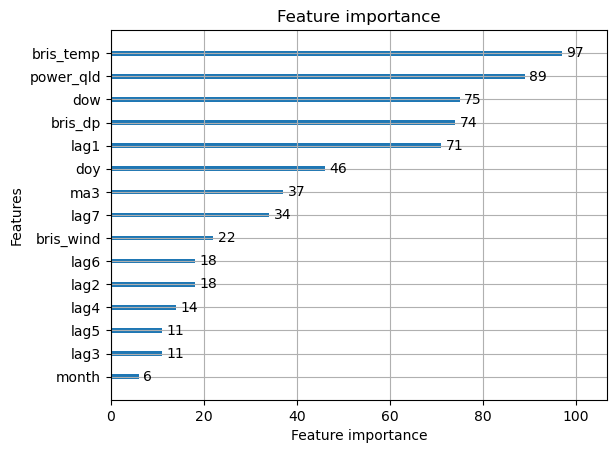

In [302]:
# LGB feature importance - split counts
lgb.plot_importance(gs_lgb_ma3.best_estimator_)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

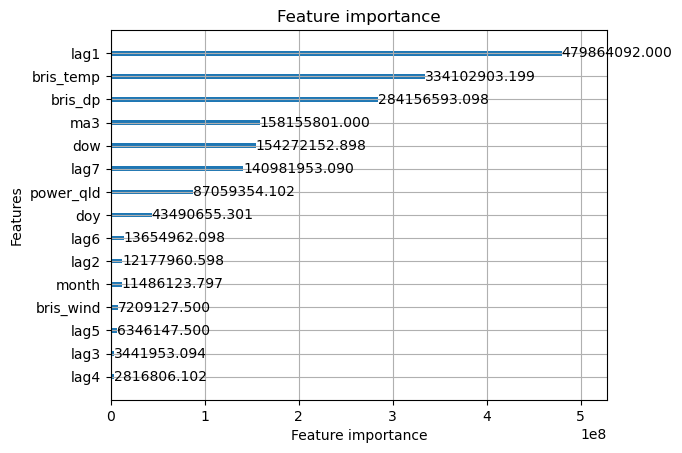

In [303]:
# LGB importance - accuracy improvement = 'gain'
lgb.plot_importance(gs_lgb_ma3.best_estimator_, importance_type='gain')

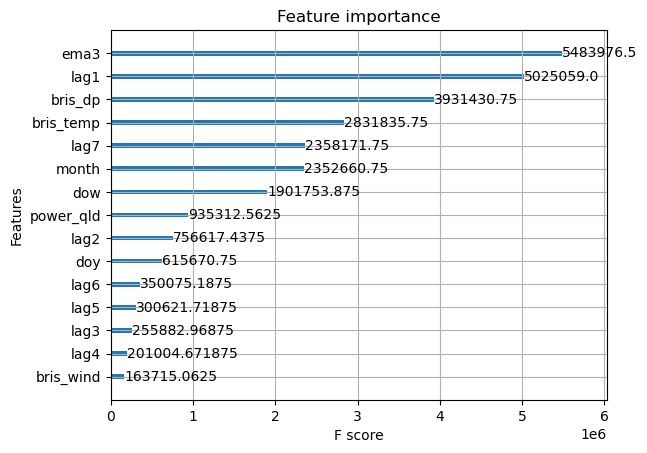

In [304]:
# Feature importance for best XGB model (EMA3) - 'gain' measures using imporovement in accuracy from feature
plot_importance(gs_xgb_ema3.best_estimator_, importance_type='gain')
plt.show()

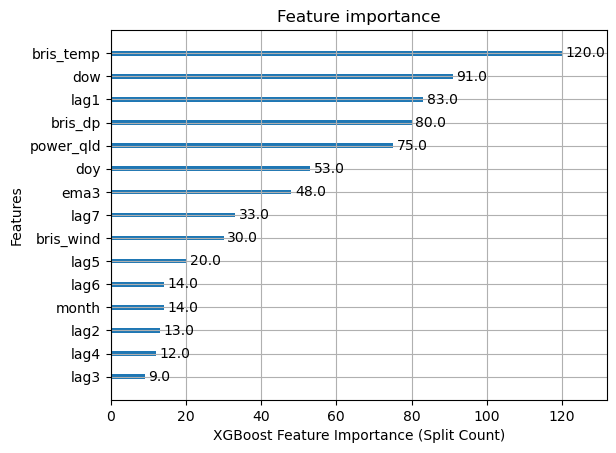

In [305]:
# XGBoost importance - split counts
plot_importance(gs_xgb_ema3.best_estimator_, importance_type='weight', xlabel='XGBoost Feature Importance (Split Count)')
#plt.gca().invert_yaxis()
plt.show()

XGBoost Model - EMA3 Features


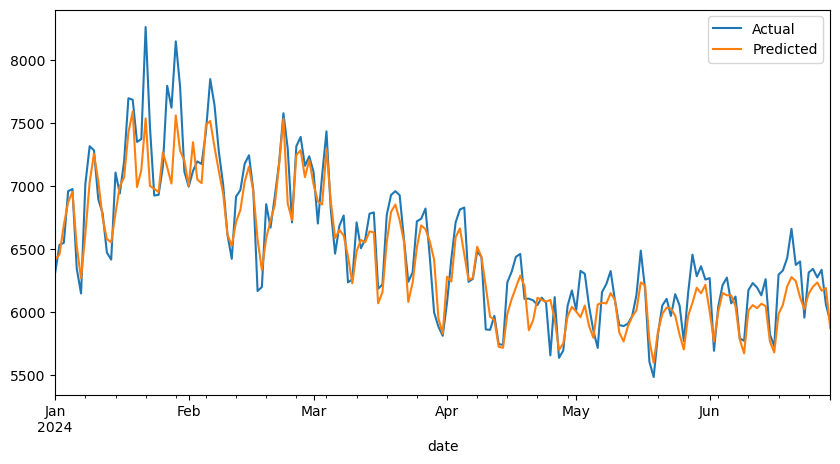

MAE: 150.8181786300069
MSE: 40007.09999629411
MAPE: 0.02268689336088113


In [306]:
# XGBoost - Best Model with EMA3
xgb_prediction = gs_xgb_ema3.predict(X_test_ema3)
print("XGBoost Model - EMA3 Features")
plot_predictions(testing_dates, y_test, xgb_prediction)
evaluate_model(y_test, xgb_prediction)



LightGBM Model - MA3 Features


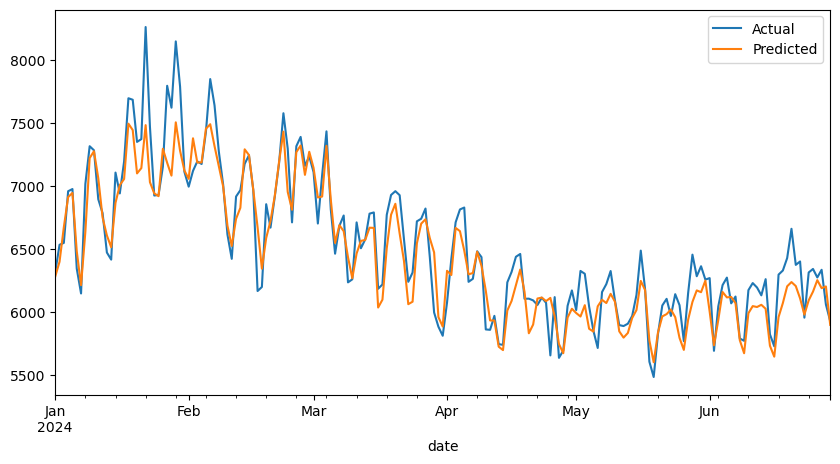

MAE: 148.4519414361979
MSE: 40135.02443457906
MAPE: 0.02243508835956928


In [307]:
# LightGBM - Best Model with MA3
lgb_prediction = gs_lgb_ma3.predict(X_test_ma3)
print("\nLightGBM Model - MA3 Features")
plot_predictions(testing_dates, y_test, lgb_prediction)
evaluate_model(y_test, lgb_prediction)


Random Forest Model - EMA2 Features


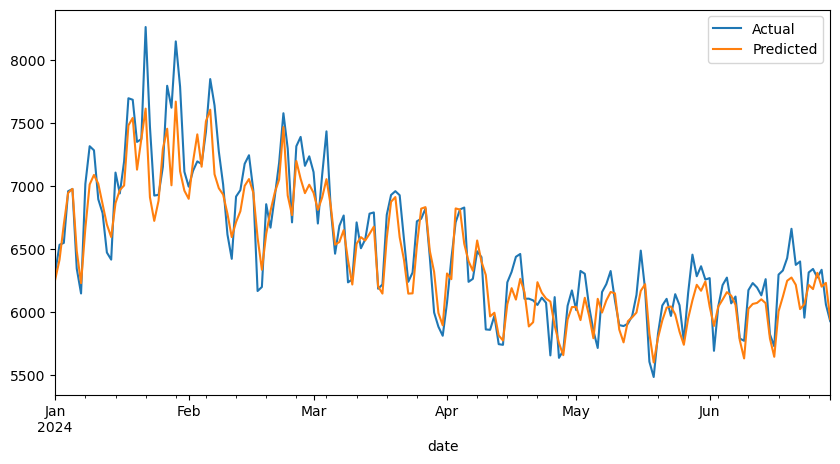

MAE: 158.6072134535444
MSE: 41559.50906590194
MAPE: 0.023892807120108387


In [308]:
# Random Forest - Best Model with EMA2
rf_prediction = gs_rf_ema2.predict(X_test_ema2)
print("\nRandom Forest Model - EMA2 Features")
plot_predictions(testing_dates, y_test, rf_prediction)
evaluate_model(y_test, rf_prediction)

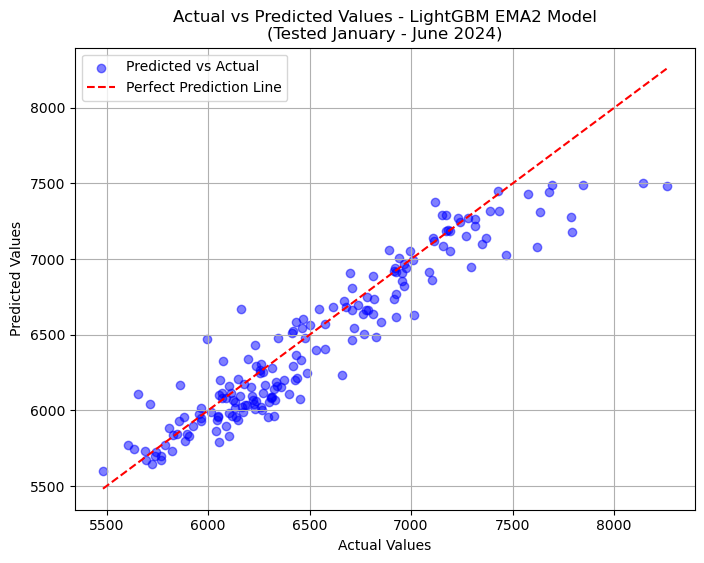

In [309]:
# Plotting pred v actual of best model - LGBM EMA2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lgb_prediction, alpha=0.5, color='blue', label='Predicted vs Actual')

# Plot a diagonal line for perfect predictions
max_val = max(max(y_test), max(lgb_prediction))
min_val = min(min(y_test), min(lgb_prediction))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')

# Set plot labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - LightGBM EMA2 Model\n(Tested January - June 2024)')
plt.legend()
plt.grid(True)
plt.show()

## Observations

- Best model for each: XGB (EMA3), LGB (MA3), RF (EMA2) - MAPE for each XGB 2.27%, LGB 2.24%, RF 2.39%
- LightGBM best performer - 3 day MA / EMA best for this
- XGB not far behind, LGB tends to vary more for different window sizes
- RF quite a bit behind each in terms of performance
- lag 1 and lag 7 clearly most informative lags (not unsurprisingly)
- quite a bit of difference in the split counts LGB v XGB
- shorter MA/EMAs tend to be preferred (perform better) - 2/3 days generally better than 5/7
- now testing lag removal to gauge improvement in performance - will test first 7 v 4 (1, 2, 3, 7), each combined with 2 and 3 day EMA/MAs, similar to above process
- some clear outliers on above plot to the rop right as model underestimates high demand levels

In [310]:
# Preparing train and test sets
X_train_ma3_lags3 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "ma3"]]
X_test_ma3_lags3 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "ma3"]]
X_train_ma3_lags3_7 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma3"]]
X_test_ma3_lags3_7 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma3"]]
y_train = training_data["dem_act"]
y_test = testing_data["dem_act"]

X_train_ema3_lags3 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "ema3"]]
X_test_ema3_lags3 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "ema3"]]
X_train_ema3_lags3_7 = training_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema3"]]
X_test_ema3_lags3_7 = testing_data[["dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema3"]]

In [311]:
# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_xgb_lag_ma = XGBRegressor()
parameters_xgb = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.5, 0.7]
}

grid_search_xgb_lag_ma3_lags3 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma3_lags3_7 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

grid_search_xgb_lag_ema3_lags3 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema3_lags3_7 = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

In [312]:
# Running GSs for each XGB model variation
gs_xgb_ma3_lags3 = grid_search_xgb_lag_ma3_lags3.fit(X_train_ma3_lags3, y_train)
gs_xgb_ema3_lags3 = grid_search_xgb_lag_ema3_lags3.fit(X_train_ema3_lags3, y_train)
gs_xgb_ma3_lags3_7 = grid_search_xgb_lag_ma3_lags3_7.fit(X_train_ma3_lags3_7, y_train)
gs_xgb_ema3_lags3_7 = grid_search_xgb_lag_ema3_lags3_7.fit(X_train_ema3_lags3_7, y_train)

In [313]:
# LightGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model_lgb_lag_ma = lgb.LGBMRegressor()
parameters_lgb = {
    "max_depth": [3, 5],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7]
}

# Suppress output
lgbm_params = {"verbosity": -1}
model_lgb_lag_ma.set_params(**lgbm_params)

# Assigning one GS for each
grid_search_lgb_lag_ma3_lags3 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma3_lags3_7 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

grid_search_lgb_lag_ema3_lags3 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema3_lags3_7 = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

In [314]:
# Running 8 x GSs for each LGB model variation
gs_lgb_ma3_lags3 = grid_search_lgb_lag_ma3_lags3.fit(X_train_ma3_lags3, y_train)
gs_lgb_ma3_lags3_7 = grid_search_lgb_lag_ma3_lags3_7.fit(X_train_ma3_lags3_7, y_train)

gs_lgb_ema3_lags3 = grid_search_lgb_lag_ema3_lags3.fit(X_train_ema3_lags3, y_train)
gs_lgb_ema3_lags3_7 = grid_search_lgb_lag_ema3_lags3_7.fit(X_train_ema3_lags3_7, y_train)

In [315]:
# Evaluating
print("\n--- Evaluating Model: XGBoost with MA3 & 3 Lags ---")
xgb_lag_ma3_lags3_prediction = gs_xgb_ma3_lags3.predict(X_test_ma3_lags3)
evaluate_model(y_test, xgb_lag_ma3_lags3_prediction)
print("\n--- Evaluating Model: XGBoost with EMA3 & 3 Lags ---")
xgb_lag_ema3_lags3_prediction = gs_xgb_ema3_lags3.predict(X_test_ema3_lags3)
evaluate_model(y_test, xgb_lag_ema3_lags3_prediction)

print("\n--- Evaluating Model: XGBoost with MA3 & 4 Lags (1, 2, 3, 7) ---")
xgb_lag_ma3_lags3_7_prediction = gs_xgb_ma3_lags3_7.predict(X_test_ma3_lags3_7)
evaluate_model(y_test, xgb_lag_ma3_lags3_7_prediction)
print("\n--- Evaluating Model: XGBoost with EMA3 & 4 Lags (1, 2, 3, 7) ---")
xgb_lag_ema3_lags3_7_prediction = gs_xgb_ema3_lags3_7.predict(X_test_ema3_lags3_7)
evaluate_model(y_test, xgb_lag_ema3_lags3_7_prediction)


--- Evaluating Model: XGBoost with MA3 & 3 Lags ---
MAE: 150.63087376266114
MSE: 39241.9375133172
MAPE: 0.02265577579039456

--- Evaluating Model: XGBoost with EMA3 & 3 Lags ---
MAE: 152.08400056111878
MSE: 39238.48332082194
MAPE: 0.022881451223948177

--- Evaluating Model: XGBoost with MA3 & 4 Lags (1, 2, 3, 7) ---
MAE: 152.75396829678868
MSE: 40453.74310836082
MAPE: 0.023078147079227698

--- Evaluating Model: XGBoost with EMA3 & 4 Lags (1, 2, 3, 7) ---
MAE: 145.29565474648942
MSE: 37415.21161982983
MAPE: 0.021969287328733607


In [316]:
# Evaluating
print("\n--- Evaluating Model: LightGBM with MA3 & 3 Lags ---")
lgb_lag_ma3_lags3_prediction = gs_lgb_ma3_lags3.predict(X_test_ma3_lags3)
evaluate_model(y_test, lgb_lag_ma3_lags3_prediction)
print("\n--- Evaluating Model: LightGBM with EMA3 & 3 Lags ---")
lgb_lag_ema3_lags3_prediction = gs_lgb_ema3_lags3.predict(X_test_ema3_lags3)
evaluate_model(y_test, lgb_lag_ema3_lags3_prediction)

print("\n--- Evaluating Model: LightGBM with MA3 & 4 Lags (1, 2, 3, 7) ---")
lgb_lag_ma3_lags3_7_prediction = gs_lgb_ma3_lags3_7.predict(X_test_ma3_lags3_7)
evaluate_model(y_test, lgb_lag_ma3_lags3_7_prediction)
print("\n--- Evaluating Model: LightGBM with EMA3 & 4 Lags (1, 2, 3, 7) ---")
lgb_lag_ema3_lags3_7_prediction = gs_lgb_ema3_lags3_7.predict(X_test_ema3_lags3_7)
evaluate_model(y_test, lgb_lag_ema3_lags3_7_prediction)


--- Evaluating Model: LightGBM with MA3 & 3 Lags ---
MAE: 155.8355700085478
MSE: 42761.72877981367
MAPE: 0.023429303126277504

--- Evaluating Model: LightGBM with EMA3 & 3 Lags ---
MAE: 155.10913423942856
MSE: 42418.50692346491
MAPE: 0.023300422056499726

--- Evaluating Model: LightGBM with MA3 & 4 Lags (1, 2, 3, 7) ---
MAE: 144.75373839371045
MSE: 37129.20140323237
MAPE: 0.02192015342621704

--- Evaluating Model: LightGBM with EMA3 & 4 Lags (1, 2, 3, 7) ---
MAE: 141.21807175689972
MSE: 35551.72626700763
MAPE: 0.021409085042085184


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

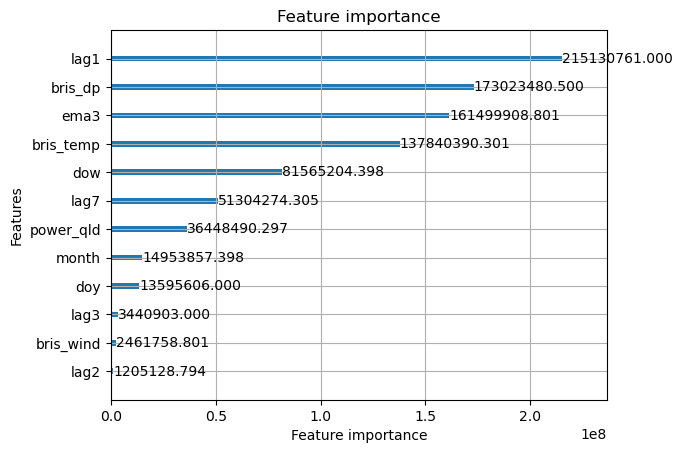

In [317]:
# LGB importance - accuracy improvement = 'gain'
lgb.plot_importance(gs_lgb_ema3_lags3_7.best_estimator_, importance_type='gain')

### Observe
- Previous best MAPEs for each XGB 2.27% (EMA3), LGB 2.24% (MA3)
- New best MAPEs for each are XGB 2.20% (lags 1, 2, 3, 7 + EMA3), LGB 2.14% (lags 1, 2, 3, 7 + EMA3)
- note best moving average has changed for each - model dependent on input variables, naturally

## Forecasting Models - With Interconnector IC Data (2023 - 2024)

Only building XGBoost & LightGBM here given superior performance to RF. Using only 2 & 3 day MA/EMAs as they appear more important.

Note now using daily_ic_df.

In [318]:
daily_ic_df.head(5)

date   net_ic_flow    dem_poe10    dem_poe50    dem_poe90  \
0 2023-03-06 -204433.72496  6613.166667  6516.916667  6420.854167   
1 2023-03-07 -146879.12472  6898.395833  6797.750000  6697.000000   
2 2023-03-08  -47579.92761  7276.916667  7170.583333  7064.500000   
3 2023-03-09  -26352.12395  7265.458333  7159.437500  7053.333333   
4 2023-03-10  -87712.82305  6900.666667  6800.604167  6700.562500   

       dem_act         rrp   power_qld  bris_temp  bris_wind  ...  dow  doy  \
0  6517.416667   83.485243  102113.555  25.070833   3.200000  ...    0   65   
1  6798.666667   83.655000   97454.941  26.427083   3.179167  ...    1   66   
2  7169.791667   83.664271   57054.973  27.000000   2.489583  ...    2   67   
3  7161.625000  101.587153   43981.622  26.633333   1.295833  ...    3   68   
4  6800.520833   96.059514   54227.769  24.579167   2.150000  ...    4   69   

   month         lag1         lag2         lag3         lag4  lag5  lag6  lag7  
0      3          NaN          NaN          NaN          NaN   NaN   NaN   NaN  
1      3  6007.108696          NaN          NaN          NaN   NaN   NaN   NaN  
2      3  5849.354167  6007.108696          NaN          NaN   NaN   NaN   NaN  
3      3  6095.895833  5849.354167  6007.108696          NaN   NaN   NaN   NaN  
4      3  6830.958333  6095.895833  5849.354167  6007.108696   NaN   NaN   NaN  

[5 rows x 22 columns]

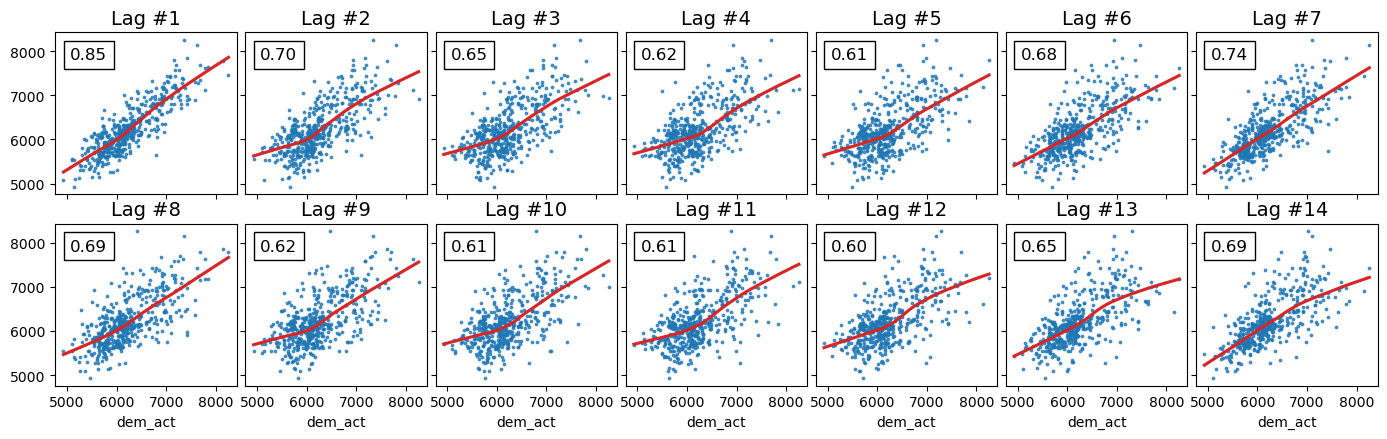

In [319]:
acf = plot_autocorrelation(daily_ic_df["dem_act"], lags=14)

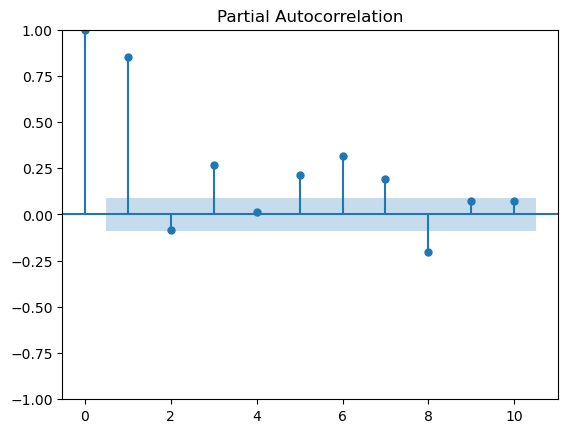

In [320]:
pacf = plot_pacf(daily_ic_df["dem_act"], lags=10)

In [321]:
# Adding rolling avg cols - IC df
daily_ic_df['ma3'] = daily_ic_df['dem_act'].shift(1).rolling(window=3).mean()
daily_ic_df['ma2'] = daily_ic_df['dem_act'].shift(1).rolling(window=2).mean()

# EMA cols - IC df
daily_ic_df['ema3'] = daily_ic_df['dem_act'].shift(1).ewm(span=3, adjust=False).mean()
daily_ic_df['ema2'] = daily_ic_df['dem_act'].shift(1).ewm(span=2, adjust=False).mean()

In [322]:
# Splitting by date - train 12 months, test 4 months
training_mask_ic = daily_ic_df["date"] < "2024-03-06"
training_data_ic = daily_ic_df.loc[training_mask_ic]
print(training_data_ic.shape)

testing_mask_ic = daily_ic_df["date"] >= "2024-03-06"
testing_data_ic = daily_ic_df.loc[testing_mask_ic]
print(testing_data_ic.shape)

(366, 26)
(116, 26)


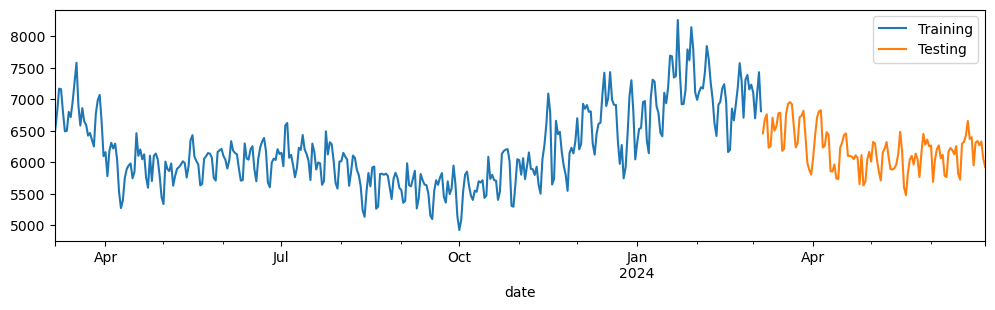

In [323]:
# Plotting train/test split over time
figure, ax = plt.subplots(figsize=(12, 3))
training_data_ic.plot(ax=ax, label="Training", x="date", y="dem_act")
testing_data_ic.plot(ax=ax, label="Testing", x="date", y="dem_act")
plt.show()

In [324]:
# Preparing train and test sets for MAs
training_data_ic = training_data_ic.drop(columns=["date"])
testing_dates = testing_data_ic["date"]
testing_data_ic = testing_data_ic.drop(columns=["date"])

X_train_ma2 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma2"]]
X_train_ma3 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma3"]]
y_train = training_data_ic["dem_act"]

X_test_ma2 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma2"]]
X_test_ma3 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ma3"]]
y_test = testing_data_ic["dem_act"]

In [325]:
# EMAs
X_train_ema2 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema2"]]
X_train_ema3 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema3"]]

X_test_ema2 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema2"]]
X_test_ema3 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "ema3"]]

In [326]:
# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=75) # reducing training size from larger sample
model_xgb_lag_ma = XGBRegressor()
parameters_xgb = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.5, 0.7]
}

grid_search_xgb_lag_ma2_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma3_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

grid_search_xgb_lag_ema2_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema3_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

In [327]:
# Running 4 x GSs for each XGB model variation
gs_xgb_ma2_ic = grid_search_xgb_lag_ma2_ic.fit(X_train_ma2, y_train)
gs_xgb_ma3_ic = grid_search_xgb_lag_ma3_ic.fit(X_train_ma3, y_train)

gs_xgb_ema2_ic = grid_search_xgb_lag_ema2_ic.fit(X_train_ema2, y_train)
gs_xgb_ema3_ic = grid_search_xgb_lag_ema3_ic.fit(X_train_ema3, y_train)

In [328]:
# LightGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=75)
model_lgb_lag_ma = lgb.LGBMRegressor()
parameters_lgb = {
    "max_depth": [3, 5],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7]
}

# Suppress LightGBM output
lgbm_params = {"verbosity": -1}
model_lgb_lag_ma.set_params(**lgbm_params)

# Assigning one GS for each
grid_search_lgb_lag_ma2_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma3_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

grid_search_lgb_lag_ema2_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema3_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

In [329]:
# Running GSs for each LGB model variation
gs_lgb_ma2_ic = grid_search_lgb_lag_ma2_ic.fit(X_train_ma2, y_train)
gs_lgb_ma3_ic = grid_search_lgb_lag_ma3_ic.fit(X_train_ma3, y_train)

gs_lgb_ema2_ic = grid_search_lgb_lag_ema2_ic.fit(X_train_ema2, y_train)
gs_lgb_ema3_ic = grid_search_lgb_lag_ema3_ic.fit(X_train_ema3, y_train)

In [330]:
# Evaluating GridSearch results - XGBoost
print("\n--- Evaluating Model: XGBoost with MA2 & 7 lags ---")
xgb_lag_ma2_prediction = gs_xgb_ma2_ic.predict(X_test_ma2)
evaluate_model(y_test, xgb_lag_ma2_prediction)
print("\n--- Evaluating Model: XGBoost with MA3 & 7 lags ---")
xgb_lag_ma3_prediction = gs_xgb_ma3_ic.predict(X_test_ma3)
evaluate_model(y_test, xgb_lag_ma3_prediction)

print("\n--- Evaluating Model: XGBoost with EMA2 & 7 lags ---")
xgb_lag_ema2_prediction = gs_xgb_ema2_ic.predict(X_test_ema2)
evaluate_model(y_test, xgb_lag_ema2_prediction)
print("\n--- Evaluating Model: XGBoost with EMA3 & 7 lags ---")
xgb_lag_ema3_prediction = gs_xgb_ema3_ic.predict(X_test_ema3)
evaluate_model(y_test, xgb_lag_ema3_prediction)


--- Evaluating Model: XGBoost with MA2 & 7 lags ---
MAE: 126.14391809222343
MSE: 24823.157510062065
MAPE: 0.020305141216821

--- Evaluating Model: XGBoost with MA3 & 7 lags ---
MAE: 136.9265220905173
MSE: 29405.719642289765
MAPE: 0.022029287697676973

--- Evaluating Model: XGBoost with EMA2 & 7 lags ---
MAE: 122.2134673019936
MSE: 23008.998366003074
MAPE: 0.01967111524787696

--- Evaluating Model: XGBoost with EMA3 & 7 lags ---
MAE: 128.63012414691093
MSE: 27341.053898727765
MAPE: 0.020675509462146278


In [331]:
# Evaluating GridSearch results - LightGBM
print("\n--- Evaluating Model: LightGBM with MA2 & 7 lags ---")
lgb_lag_ma2_prediction = gs_lgb_ma2_ic.predict(X_test_ma2)
evaluate_model(y_test, lgb_lag_ma2_prediction)
print("\n--- Evaluating Model: LightGBM with MA3 & 7 lags ---")
lgb_lag_ma3_prediction = gs_lgb_ma3_ic.predict(X_test_ma3)
evaluate_model(y_test, lgb_lag_ma3_prediction)

print("\n--- Evaluating Model: LightGBM with EMA2 & 7 lags ---")
lgb_lag_ema2_prediction = gs_lgb_ema2_ic.predict(X_test_ema2)
evaluate_model(y_test, lgb_lag_ema2_prediction)
print("\n--- Evaluating Model: LightGBM with EMA3 & 7 lags ---")
lgb_lag_ema3_prediction = gs_lgb_ema3_ic.predict(X_test_ema3)
evaluate_model(y_test, lgb_lag_ema3_prediction)


--- Evaluating Model: LightGBM with MA2 & 7 lags ---
MAE: 120.42024992841486
MSE: 23986.68239576004
MAPE: 0.01931821157288513

--- Evaluating Model: LightGBM with MA3 & 7 lags ---
MAE: 135.15719661058344
MSE: 28524.701582853686
MAPE: 0.0216234539399315

--- Evaluating Model: LightGBM with EMA2 & 7 lags ---
MAE: 119.03899026779246
MSE: 23439.347605138988
MAPE: 0.019096839649171863

--- Evaluating Model: LightGBM with EMA3 & 7 lags ---
MAE: 134.4358899807907
MSE: 28155.490281290553
MAPE: 0.021523017418700493


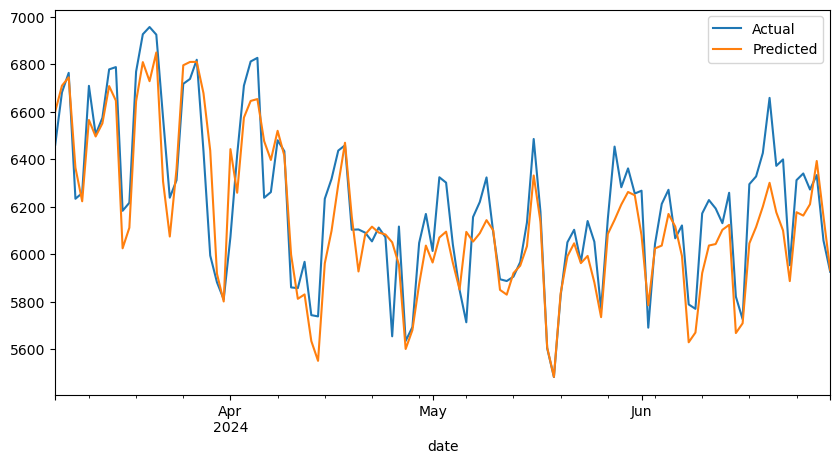

MAE: 119.03899026779246
MSE: 23439.347605138988
MAPE: 0.019096839649171863


In [332]:
# Plotting EMA2 LGBM
lgb_prediction = gs_lgb_ema2_ic.predict(X_test_ema2)
plot_predictions(testing_dates, y_test, lgb_prediction)
evaluate_model(y_test, lgb_prediction)

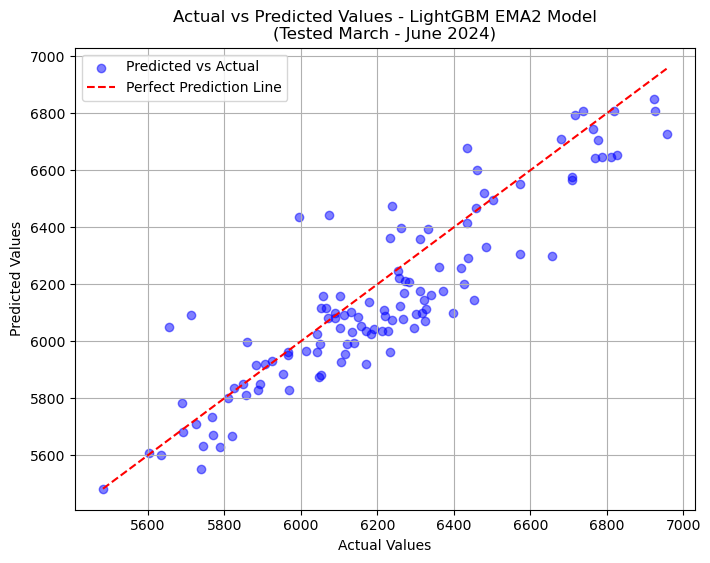

In [333]:
# Plotting pred v actual of best model - LGBM EMA2
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lgb_lag_ema2_prediction, alpha=0.5, color='blue', label='Predicted vs Actual')

# Plot a diagonal line for perfect predictions
max_val = max(max(y_test), max(lgb_lag_ema2_prediction))
min_val = min(min(y_test), min(lgb_lag_ema2_prediction))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')

# Set plot labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - LightGBM EMA2 Model\n(Tested March - June 2024)')
plt.legend()
plt.grid(True)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

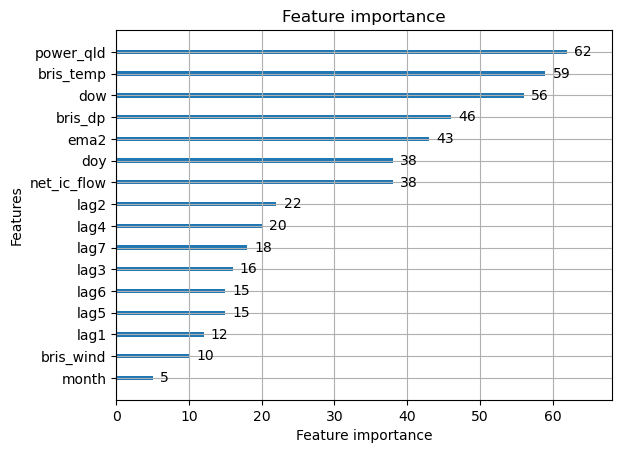

In [334]:
# Feature importances of best model
lgb.plot_importance(gs_lgb_ema2_ic.best_estimator_) # based on split counts

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

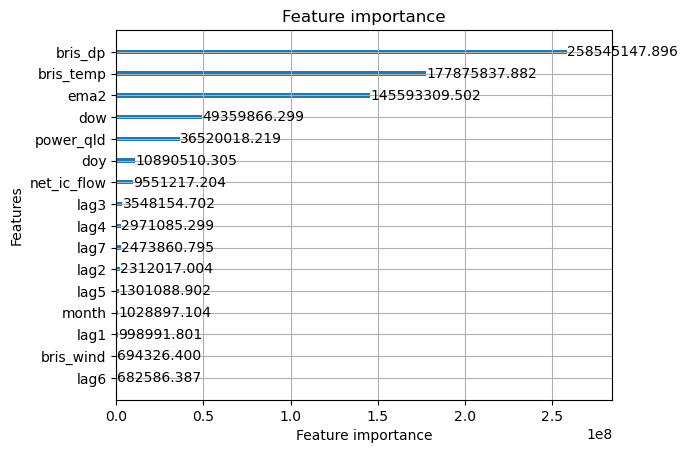

In [335]:
# LGB importance - accuracy improvement = 'gain'
lgb.plot_importance(gs_lgb_ema2_ic.best_estimator_, importance_type='gain')

## Observations

- Observe including the IC data reduces best MAPE from 2.24% to 1.91% (LightGBM for both) with all 7 lags
- Best XGBoost model also reduced MAPE from 2.27% to 1.97%
- Actual v predicted shows the majority of points are clustered beneath the line, meaning typically actual > predicted
- However, there are some extreme points that lie some distance 'above' the optimal prediction line, meaning sometimes the predicted is far higher than actual
- Overall determine demand is incredibly volatile and its extremes are not fully captured in the proposed models as there remains unexplained variability
- Could be additional predictors not captured in the model that are useful (find sources of other models)
- A different testing period (note extremes not captures in Jan/Feb) - could test on same 6 months which would represent approx. 60/40 split (~9 months v 6 months) for proper like for like comparison (although reduced training set)
- Only issue though is that any day prior to Mar 6 2024 the test set encapsulates means the training model does not see an equivalent day so time of year effects are not captured in training set

### Removing lags 4, 5, 6 and testing for improvements

In [336]:
# Reducing lags to 1, 2, 3, 7 only
X_train_ma2 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma2"]]
X_train_ma3 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma3"]]
y_train = training_data_ic["dem_act"]

X_test_ma2 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma2"]]
X_test_ma3 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ma3"]]
y_test = testing_data_ic["dem_act"]

X_train_ema2 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema2"]]
X_train_ema3 = training_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema3"]]

X_test_ema2 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema2"]]
X_test_ema3 = testing_data_ic[["net_ic_flow", "dow", "doy", "month", "power_qld", "bris_temp", "bris_wind", "bris_dp", "lag1", "lag2", "lag3", "lag7", "ema3"]]

In [337]:
# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=75) # reducing training size from larger sample
model_xgb_lag_ma = XGBRegressor()
parameters_xgb = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "colsample_bytree": [0.5, 0.7]
}

grid_search_xgb_lag_ma2_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ma3_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

grid_search_xgb_lag_ema2_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)
grid_search_xgb_lag_ema3_ic = GridSearchCV(estimator=model_xgb_lag_ma, cv=cv_split, param_grid=parameters_xgb)

In [338]:
# Running 4 x GSs for each XGB model variation
gs_xgb_ma2_ic = grid_search_xgb_lag_ma2_ic.fit(X_train_ma2, y_train)
gs_xgb_ma3_ic = grid_search_xgb_lag_ma3_ic.fit(X_train_ma3, y_train)

gs_xgb_ema2_ic = grid_search_xgb_lag_ema2_ic.fit(X_train_ema2, y_train)
gs_xgb_ema3_ic = grid_search_xgb_lag_ema3_ic.fit(X_train_ema3, y_train)

In [339]:
# LightGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=75)
model_lgb_lag_ma = lgb.LGBMRegressor()
parameters_lgb = {
    "max_depth": [3, 5],
    "num_leaves": [10, 20],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7]
}

# Suppress LightGBM output
lgbm_params = {"verbosity": -1}
model_lgb_lag_ma.set_params(**lgbm_params)

# Assigning one GS for each
grid_search_lgb_lag_ma2_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ma3_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

grid_search_lgb_lag_ema2_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)
grid_search_lgb_lag_ema3_ic = GridSearchCV(estimator=model_lgb_lag_ma, cv=cv_split, param_grid=parameters_lgb, verbose=0)

In [340]:
# Running GSs for each LGB model variation
gs_lgb_ma2_ic = grid_search_lgb_lag_ma2_ic.fit(X_train_ma2, y_train)
gs_lgb_ma3_ic = grid_search_lgb_lag_ma3_ic.fit(X_train_ma3, y_train)

gs_lgb_ema2_ic = grid_search_lgb_lag_ema2_ic.fit(X_train_ema2, y_train)
gs_lgb_ema3_ic = grid_search_lgb_lag_ema3_ic.fit(X_train_ema3, y_train)

In [341]:
# Evaluating GridSearch results - XGBoost
print("\n--- Evaluating Model: XGBoost with MA2 & lags 1, 2, 3, 7 ---")
xgb_lag_ma2_prediction = gs_xgb_ma2_ic.predict(X_test_ma2)
evaluate_model(y_test, xgb_lag_ma2_prediction)
print("\n--- Evaluating Model: XGBoost with MA3 & lags 1, 2, 3, 7 ---")
xgb_lag_ma3_prediction = gs_xgb_ma3_ic.predict(X_test_ma3)
evaluate_model(y_test, xgb_lag_ma3_prediction)

print("\n--- Evaluating Model: XGBoost with EMA2 & lags 1, 2, 3, 7 ---")
xgb_lag_ema2_prediction = gs_xgb_ema2_ic.predict(X_test_ema2)
evaluate_model(y_test, xgb_lag_ema2_prediction)
print("\n--- Evaluating Model: XGBoost with EMA3 & lags 1, 2, 3, 7 ---")
xgb_lag_ema3_prediction = gs_xgb_ema3_ic.predict(X_test_ema3)
evaluate_model(y_test, xgb_lag_ema3_prediction)


--- Evaluating Model: XGBoost with MA2 & lags 1, 2, 3, 7 ---
MAE: 131.42964961610997
MSE: 28263.406089447704
MAPE: 0.02107686660279689

--- Evaluating Model: XGBoost with MA3 & lags 1, 2, 3, 7 ---
MAE: 131.17833350170622
MSE: 27416.70166551862
MAPE: 0.020989243538578325

--- Evaluating Model: XGBoost with EMA2 & lags 1, 2, 3, 7 ---
MAE: 129.4736356187141
MSE: 27097.377634998033
MAPE: 0.02075810331003114

--- Evaluating Model: XGBoost with EMA3 & lags 1, 2, 3, 7 ---
MAE: 119.21938280127519
MSE: 23157.52528975819
MAPE: 0.0191495406142655


In [342]:
# Evaluating GridSearch results - LightGBM
print("\n--- Evaluating Model: LightGBM with MA2 & lags 1, 2, 3, 7 ---")
lgb_lag_ma2_prediction = gs_lgb_ma2_ic.predict(X_test_ma2)
evaluate_model(y_test, lgb_lag_ma2_prediction)
print("\n--- Evaluating Model: LightGBM with MA3 & lags 1, 2, 3, 7 ---")
lgb_lag_ma3_prediction = gs_lgb_ma3_ic.predict(X_test_ma3)
evaluate_model(y_test, lgb_lag_ma3_prediction)

print("\n--- Evaluating Model: LightGBM with EMA2 & lags 1, 2, 3, 7 ---")
lgb_lag_ema2_prediction = gs_lgb_ema2_ic.predict(X_test_ema2)
evaluate_model(y_test, lgb_lag_ema2_prediction)
print("\n--- Evaluating Model: LightGBM with EMA3 & lags 1, 2, 3, 7 ---")
lgb_lag_ema3_prediction = gs_lgb_ema3_ic.predict(X_test_ema3)
evaluate_model(y_test, lgb_lag_ema3_prediction)


--- Evaluating Model: LightGBM with MA2 & lags 1, 2, 3, 7 ---
MAE: 130.27803954969713
MSE: 26220.86859314275
MAPE: 0.020868503531449097

--- Evaluating Model: LightGBM with MA3 & lags 1, 2, 3, 7 ---
MAE: 141.17880648768568
MSE: 29686.687664587047
MAPE: 0.02267619167338407

--- Evaluating Model: LightGBM with EMA2 & lags 1, 2, 3, 7 ---
MAE: 127.93105306772664
MSE: 25278.03636285272
MAPE: 0.02048760014330675

--- Evaluating Model: LightGBM with EMA3 & lags 1, 2, 3, 7 ---
MAE: 134.36681324444703
MSE: 28123.821518370096
MAPE: 0.02153693314945875


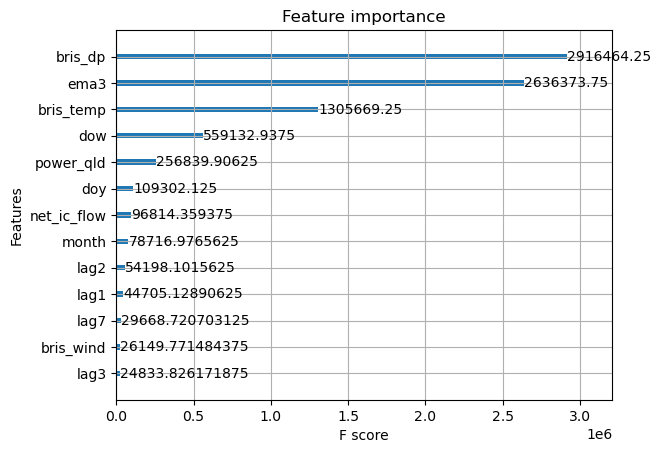

In [343]:
# XGB best model feature importance
plot_importance(gs_xgb_ema3_ic.best_estimator_, importance_type='gain')
plt.show()

## Observations
- XGBoost reduced MAPE from 1.97% to 1.91% removing lags 4, 5, 6
- LightGBM does not improve when removing these lags - performs best with all 7
- Clearly model performance dependent on feature set

## Exporting Hourly DFs

Now exporting hourly DFs with exceedance data to csv for loading and classification testing in separate notebook.

In [344]:
print(os.getcwd())

/home/n8309116/swan/IFN704 Project/Saved_DFs


In [345]:
os.chdir('/home/n8309116/swan/IFN704 Project/Saved_DFs')

In [346]:
hourly_df.to_csv('preprocessed_hourly_data2.csv', index=False)

In [347]:
hourly_ic_df.to_csv('preprocessed_hourly_ic_data2.csv', index=False)